# Analyse de sentiments pour Air Paradis
**Auteur:** Didier DRACHE  
**Date:** Mars-Avril 2025

Ce notebook présente le développement d'un système d'analyse de sentiments pour détecter les bad buzz potentiels sur les réseaux sociaux pour la compagnie aérienne Air Paradis.

## 1. Introduction et Configuration

### 1.1 Importation des bibliothèques nécessaires

Les bibliothèques ci-dessous sont utilisées pour l'analyse de données, la modélisation et le suivi des expériences.

In [1]:
# 1. Introduction et Configuration
# Projet: Détection de sentiment pour Air Paradis
# Auteur: Didier DRACHE
# Date de début: 22 mars 2025

# 1.1 Importation des bibliothèques nécessaires
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Ou '2' pour cacher aussi les warnings
import sys
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Optional, Union, Any

# Statistiques et métriques
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Prétraitement et modélisation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

# Deep Learning
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Embedding, LSTM, GRU, Bidirectional, Conv1D, GlobalMaxPooling1D,
    Dropout, BatchNormalization, Input, MaxPooling1D
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

# Tracking des expérimentations
import mlflow
import mlflow.sklearn
import mlflow.keras

# Import des fonctions utilitaires personnalisées
# Ce fichier contient toutes les fonctions réutilisables
from config import CONFIG, update_sample_size, update_lemmatization
try:
    from utils import *
except ImportError:
    print("Fichier utils.py introuvable, veuillez exécuter d'abord la cellule de création des utilitaires")
    
# Configuration de visualisation
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(style="darkgrid")

# Configuration pour éviter les avertissements
import warnings
warnings.filterwarnings('ignore')


# Forcer l'utilisation du GPU 1 (second GPU)
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Vérifier que TensorFlow voit le GPU correctement
print("TensorFlow GPUs disponibles:", tf.config.list_physical_devices('GPU'))

# Configurer l'allocation mémoire dynamique pour éviter de saturer la VRAM
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Permettre une allocation mémoire dynamique (libérable)
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Allocation mémoire dynamique activée pour tous les GPUs")
    except RuntimeError as e:
        print("Erreur lors de la configuration des GPUs:", e)

# Libérer explicitement la mémoire CUDA
def clear_gpu_memory():
    import gc
    gc.collect()
    tf.keras.backend.clear_session()
    print("Mémoire GPU libérée")

download_nltk_resources()

2025-05-19 10:50:00.700664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-19 10:50:00.700694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 10:50:00.701774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Allocation mémoire dynamique activée pour tous les GPUs


[nltk_data] Downloading package wordnet to /home/didier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/didier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/didier/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### 1.2 Création de la structure de répertoires

Configuration de TensorFlow pour utiliser efficacement les GPUs disponibles (RTX 3090) avec allocation mémoire dynamique.

In [2]:
# 1.2 Création de la structure de répertoires
created_dirs = create_directory_structure()
print(f"Répertoires créés: {created_dirs}")

Répertoires créés: []


### 1.3 Configuration de MLflow

In [3]:
# 1.3 Configuration de MLflow
experiment_id = setup_mlflow_experiment("Air Paradis - Analyse de Sentiment")
print(f"MLflow experiment ID: {experiment_id}")

MLflow experiment ID: 503455922251681920


### 1.4 Informations sur le projet et contexte métier

- **Client:** Air Paradis (compagnie aérienne)
- **Objectif:** Développer un modèle de prédiction du sentiment associé aux tweets
- **Contexte:** Anticiper les bad buzz sur les réseaux sociaux
- **Approches à tester:**
  1. Modèle sur mesure simple (classique)
  2. Modèle sur mesure avancé (deep learning)
  3. Modèle avancé BERT
  4. Modèle DistilBERT (alternative légère à BERT)

### 1.5 Informations sur l'environnement d'exécution

In [4]:
# 1.5 Informations sur l'environnement d'exécution

from IPython.display import Markdown, display

# Collecte des informations sur l'environnement
import platform, re
system_info = f"**Système:** {platform.system()} {platform.release()}"
python_info = f"**Python:** {platform.python_version()}"

# Informations GPU
gpu_info = []
if tf.config.list_physical_devices('GPU'):
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        gpu_info.append(f"GPU disponible: {gpu.name}")
        
        # Informations sur la mémoire GPU
        try:
            import torch
            gpu_info.append(f"Mémoire GPU (CUDA): {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        except:
            gpu_info.append("Impossible d'obtenir les informations de mémoire GPU via PyTorch")
else:
    gpu_info.append("Aucun GPU détecté, l'exécution sera plus lente sur CPU")

# Construction du markdown
markdown_content = f"""
- {system_info}
- {python_info}
"""

# Ajouter les informations GPU
for info in gpu_info:
    info_md =info.replace('/physical_device:','')
    info_md = re.sub(r'^([^:]+):', r'**\1:**', info_md)
    markdown_content += f"- {info_md}\n"

# Afficher le markdown
print_md(markdown_content)


- **Système:** Linux 6.8.0-60-generic
- **Python:** 3.10.13
- **GPU disponible:** GPU:0
- **Mémoire GPU (CUDA):** 25.30 GB


### 1.6 Paramètres globaux

In [5]:
# 1.6 Paramètres globaux

# Paramètres globaux pour le projet

# taille_echantillon = 100000
# taille_echantillon = 10000 # pour debug
# taille_echantillon = 20000 # pour debug
# taille_echantillon = None # tout le jeu de donnés
taille_echantillon = 100000
Utiliser_Lemmatisation = True

# Mettre à jour la configuration avec la taille d'échantillon
CONFIG = update_sample_size(taille_echantillon)
CONFIG = update_lemmatization(Utiliser_Lemmatisation)

# Fixer les graines aléatoires pour la reproductibilité
np.random.seed(CONFIG["RANDOM_SEED"])
tf.random.set_seed(CONFIG["RANDOM_SEED"])

display(CONFIG)

Taille d'échantillon mise à jour: 100000
Utilisation de la lemmatisation mise à jour: Activée


{'RANDOM_SEED': 42,
 'TEST_SIZE': 0.2,
 'VALIDATION_SIZE': 0.1,
 'MAX_FEATURES': 50000,
 'BATCH_SIZE': 64,
 'EPOCHS': 10,
 'MAX_SEQUENCE_LENGTH': 100,
 'EMBEDDING_DIM': 100,
 'DATA_PATH': 'data/training.1600000.processed.noemoticon.csv',
 'MLFLOW_TRACKING_URI': 'file:./mlruns',
 'EXPERIMENT_NAME': 'Air Paradis - Analyse de Sentiment',
 'SAMPLE_SIZE': 100000,
 'USE_LEMMATIZATION': True}

- **Graine aléatoire:** 42
- **Taille de test:** 20%
- **Taille de validation:** 10%
- **Vocabulaire maximum:** 50,000 mots
- **Taille de batch:** 64
- **Époques:** 10
- **Longueur max des séquences:** 100
- **Dimension des embeddings:** 100

## 2. Exploration et Préparation des Données

Cette section couvre le chargement, l'exploration et la préparation des données Sentiment140 pour l'entraînement des modèles.

### 2.1 Chargement des données

In [6]:
# 2. Exploration et Préparation des Données
# 2.1 Chargement des données

# Ces modèles sont maintenant définis dans utils.py pour faciliter leur réutilisation
from utils import load_sentiment140_data

# Chargement des données
result = load_sentiment140_data(CONFIG["DATA_PATH"])
df = result[0]  # On garde seulement le DataFrame, pas le temps d'exécution

Chargement du dataset depuis data/training.1600000.processed.noemoticon.csv...
Fonction load_sentiment140_data exécutée en 2.71 secondes


### 2.2 Analyse exploratoire des données

Examinons la structure des données, leur distribution et leurs caractéristiques principales pour mieux comprendre le corpus de tweets.


#### Statistiques générales du dataset:
- **Nombre total d'observations:** 1,600,000
- **Nombre de variables:** 6

#### Aperçu des données:

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."



#### Informations sur les variables:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


None


#### Statistiques descriptives du dataset:

,sentiment,id,date,flag,user,text
count,1600000.0,1.600000e+06,1600000,1600000,1600000,1600000
unique,NaN,NaN,774363,1,659775,1581466
top,NaN,NaN,Mon Jun 15 12:53:14 PDT 2009,NO_QUERY,lost_dog,isPlayer Has Died! Sorry
freq,NaN,NaN,20,1600000,549,210
mean,0.5,1.998818e+09,NaN,NaN,NaN,NaN
std,0.5,1.935761e+08,NaN,NaN,NaN,NaN
min,0.0,1.467810e+09,NaN,NaN,NaN,NaN
25%,0.0,1.956916e+09,NaN,NaN,NaN,NaN
50%,0.5,2.002102e+09,NaN,NaN,NaN,NaN
75%,1.0,2.177059e+09,NaN,NaN,NaN,NaN



#### Distribution des sentiments dans le corpus:


- **Distribution des sentiments:** 
  - Négatif: 800,000 tweets (50.0%)
  - Positif: 800,000 tweets (50.0%)


,Sentiment,Count
0,Négatif,800000
1,Positif,800000


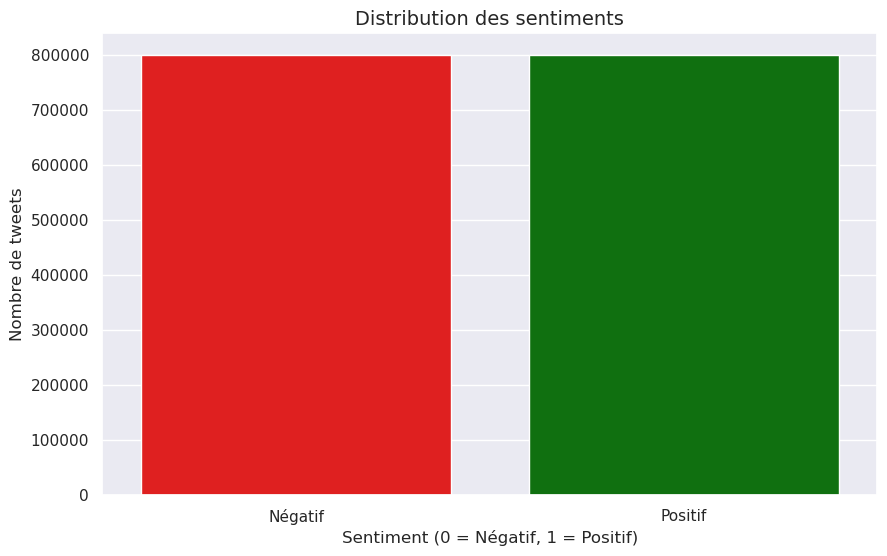

In [7]:
# 2.2 Analyse exploratoire des données

stats_markdown = f"""
#### Statistiques générales du dataset:
- **Nombre total d'observations:** {df.shape[0]:,}
- **Nombre de variables:** {df.shape[1]}"""
print_md(stats_markdown)

# print("\nAperçu des données:")
print_md(f"""#### Aperçu des données:""")
display(df.head())

# print("\nInformations sur les variables:")
print_md(f"""\n#### Informations sur les variables:""")
display(df.info())

# print("\nStatistiques descriptives:")
print_md(f"""\n#### Statistiques descriptives du dataset:""")
display(df.describe(include='all'))

# Distribution des sentiments
print_md(f"""\n#### Distribution des sentiments dans le corpus:""")
stats_markdown = f"""
- **Distribution des sentiments:** 
  - Négatif: {df[df['sentiment'] == 0].shape[0]:,} tweets ({df[df['sentiment'] == 0].shape[0]/df.shape[0]*100:.1f}%)
  - Positif: {df[df['sentiment'] == 1].shape[0]:,} tweets ({df[df['sentiment'] == 1].shape[0]/df.shape[0]*100:.1f}%)
"""
print_md(stats_markdown)

# print("\nDistribution des sentiments:")
sentiment_counts = df['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']
sentiment_counts['Sentiment'] = sentiment_counts['Sentiment'].replace({0: 'Négatif', 1: 'Positif'})
display(sentiment_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', hue='sentiment', data=df, palette=['red', 'green'],legend=False)
plt.title('Distribution des sentiments', fontsize=14)
plt.xlabel('Sentiment (0 = Négatif, 1 = Positif)')
plt.ylabel('Nombre de tweets')
plt.xticks([0, 1], ['Négatif', 'Positif'])
plt.savefig('visualisations/2_2_sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.3 Analyse du texte des tweets

Cette section explore la longueur des tweets et leur composition pour identifier des motifs potentiellement utiles pour la modélisation.


=== Analyse du texte des tweets ===



#### Caractéristiques des tweets:
- **Longueur des tweets:**
  - Moyenne: 74.09 caractères
  - Médiane: 69.00 caractères
  - Minimum: 6 caractères
  - Maximum: 374 caractères


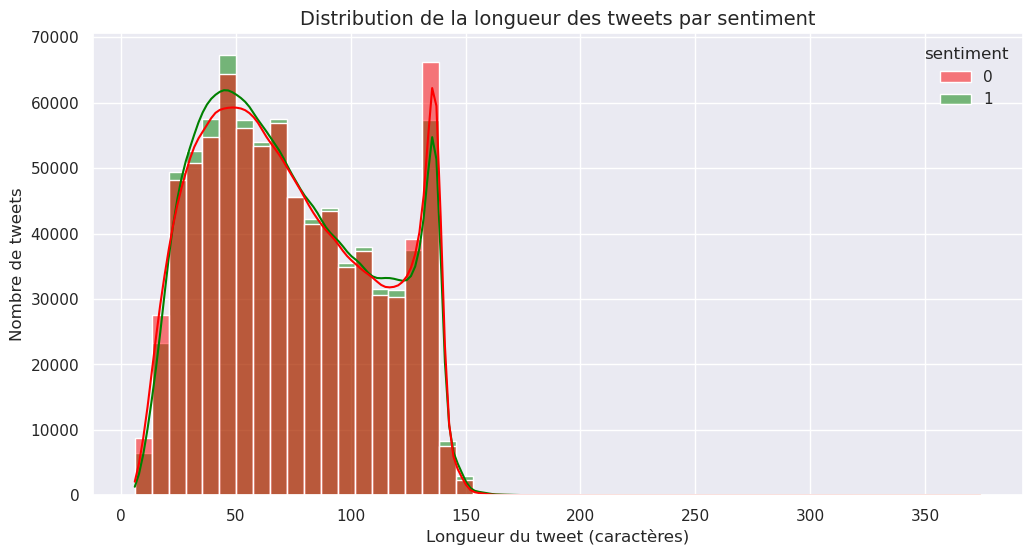


#### Nombre de mots:
- Moyenne: 13.18 mots
- Médiane: 12.00 mots
- Minimum: 1 mots
- Maximum: 64 mots


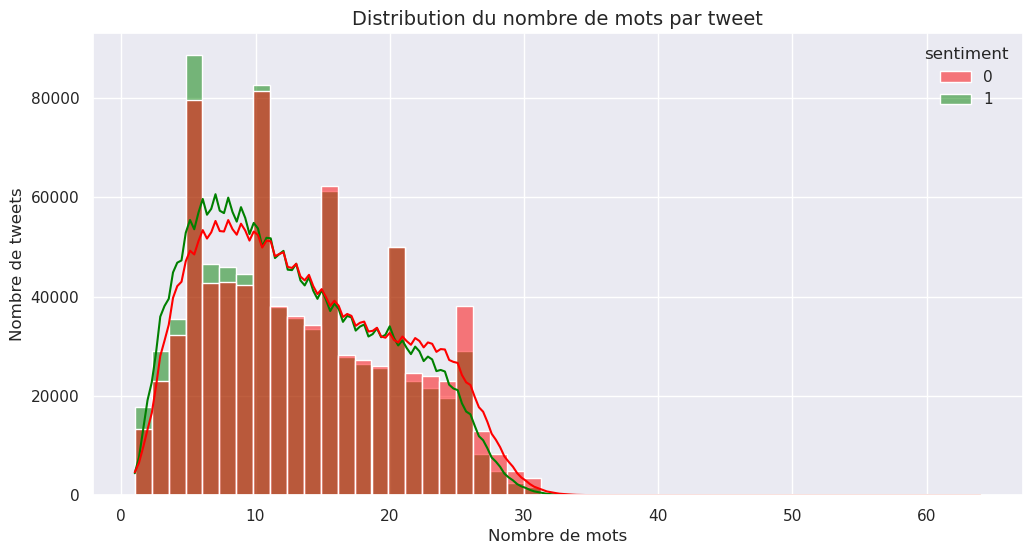

In [8]:
# 2.3 Analyse du texte des tweets
print("\n=== Analyse du texte des tweets ===")

# Longueur des tweets
df['text_length'] = df['text'].apply(len)

text_stats_markdown = f"""
#### Caractéristiques des tweets:
- **Longueur des tweets:**
  - Moyenne: {df['text_length'].mean():.2f} caractères
  - Médiane: {df['text_length'].median():.2f} caractères
  - Minimum: {df['text_length'].min()} caractères
  - Maximum: {df['text_length'].max()} caractères
"""
print_md(text_stats_markdown)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='sentiment', 
             bins=50, kde=True, palette=['red', 'green'])
plt.title('Distribution de la longueur des tweets par sentiment', fontsize=14)
plt.xlabel('Longueur du tweet (caractères)')
plt.ylabel('Nombre de tweets')
plt.savefig('visualisations/2_3_tweet_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Nombre de mots par tweet
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

text_stats_markdown = f"""
#### Nombre de mots:
- Moyenne: {df['word_count'].mean():.2f} mots
- Médiane: {df['word_count'].median():.2f} mots
- Minimum: {df['word_count'].min()} mots
- Maximum: {df['word_count'].max()} mots
"""
print_md(text_stats_markdown)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count', hue='sentiment', 
             bins=50, kde=True, palette=['red', 'green'])
plt.title('Distribution du nombre de mots par tweet', fontsize=14)
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de tweets')
plt.savefig('visualisations/2_3_word_count_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.4 Analyse des termes les plus fréquents

Identification des mots qui apparaissent le plus fréquemment dans les tweets positifs et négatifs pour comprendre les différences lexicales.

#### Termes les plus fréquents:

| Rang | Terme négatif | Fréquence | Terme positif | Fréquence |
|------|--------------|-----------|---------------|-----------|
| 1 | get | 45,379 | good | 60,869 |
| 2 | dont | 45,158 | love | 46,857 |
| 3 | work | 44,044 | day | 45,336 |
| 4 | cant | 43,766 | like | 37,116 |
| 5 | like | 40,665 | get | 36,224 |
| 6 | day | 39,482 | thanks | 33,750 |
| 7 | today | 36,209 | lol | 33,511 |
| 8 | going | 33,450 | going | 30,650 |
| 9 | got | 33,102 | time | 29,348 |
| 10 | back | 32,525 | today | 28,430 |
| 11 | really | 31,230 | got | 27,801 |
| 12 | miss | 30,506 | new | 26,645 |
| 13 | want | 29,737 | one | 25,840 |
| 14 | still | 28,765 | see | 25,468 |
| 15 | good | 28,555 | know | 25,281 |
| 16 | sad | 27,151 | great | 24,886 |
| 17 | time | 26,779 | well | 24,564 |
| 18 | one | 26,366 | back | 23,466 |
| 19 | know | 25,926 | night | 22,209 |
| 20 | home | 23,791 | dont | 22,148 |


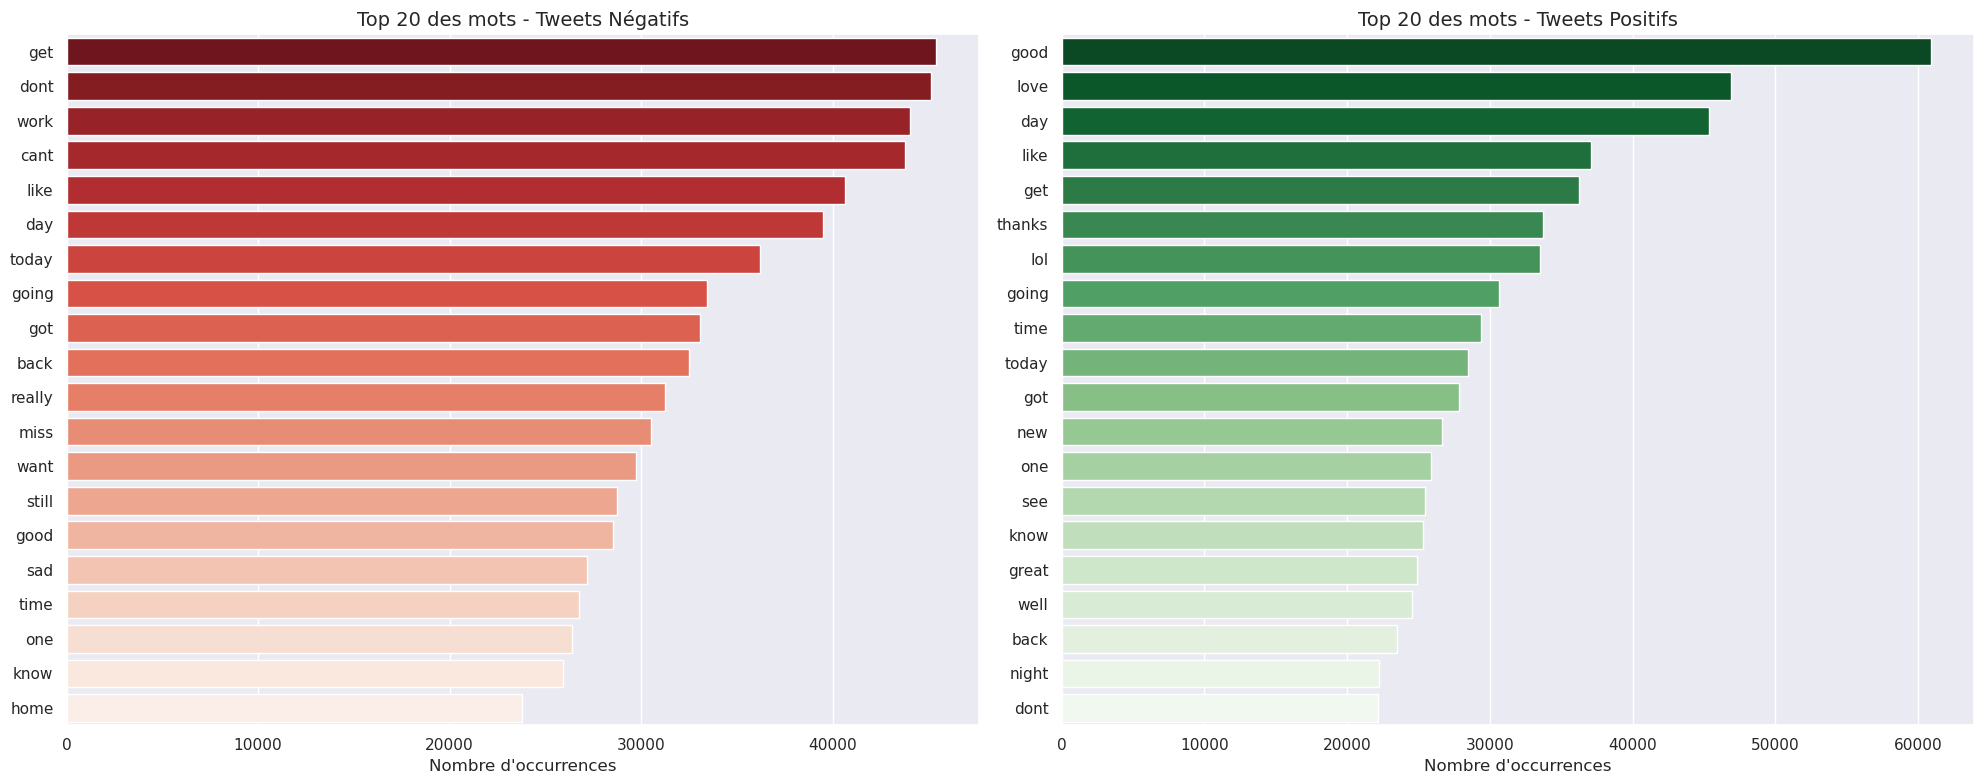

In [9]:
# 2.4 Analyse des termes les plus fréquents
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

# Ces modèles sont maintenant définis dans utils.py pour faciliter leur réutilisation
from utils import get_top_words

# Télécharger les stopwords si nécessaire
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

# Créer un markdown pour résumer les termes fréquents
terms_markdown = "#### Termes les plus fréquents:\n\n"
terms_markdown += "| Rang | Terme négatif | Fréquence | Terme positif | Fréquence |\n"
terms_markdown += "|------|--------------|-----------|---------------|-----------|\n"

# Mots les plus fréquents dans les tweets négatifs
negative_tweets = df[df['sentiment'] == 0]['text']
negative_top_words = get_top_words(negative_tweets)

# Mots les plus fréquents dans les tweets positifs
positive_tweets = df[df['sentiment'] == 1]['text']
positive_top_words = get_top_words(positive_tweets)

for i in range(min(20, len(negative_top_words), len(positive_top_words))):
    neg_word, neg_count = negative_top_words[i]
    pos_word, pos_count = positive_top_words[i]
    terms_markdown += f"| {i+1} | {neg_word} | {neg_count:,} | {pos_word} | {pos_count:,} |\n"

print_md(terms_markdown)

# Visualisation des mots les plus fréquents
plt.figure(figsize=(20, 8))

# Tweets négatifs
plt.subplot(1, 2, 1)
words, counts = zip(*negative_top_words)
sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='Reds_r',legend=False)
plt.title('Top 20 des mots - Tweets Négatifs', fontsize=14)
plt.xlabel('Nombre d\'occurrences')

# Tweets positifs
plt.subplot(1, 2, 2)
words, counts = zip(*positive_top_words)
sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='Greens_r',legend=False)
plt.title('Top 20 des mots - Tweets Positifs', fontsize=14)
plt.xlabel('Nombre d\'occurrences')

plt.tight_layout()
plt.savefig('visualisations/2_4_top_words_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.5 Prétraitement des données

Nettoyage des textes et préparation des ensembles d'entraînement et de test pour la modélisation.

In [10]:
# 2.5 Prétraitement des données

from joblib import Parallel, delayed
import multiprocessing

from utils import clean_text, preprocess_data, save_processed_data, load_processed_data

# Prétraitement des données

# Utiliser les paramètres de la configuration globale
result = preprocess_data(df, 
                        sample_size=CONFIG["SAMPLE_SIZE"], 
                        lemmatize=CONFIG["USE_LEMMATIZATION"])

X_train, X_test, y_train, y_test = result[0]  # On garde seulement les données, pas le temps d'exécution

save_processed_data(X_train, X_test, y_train, y_test)

print_md(f"""
#### Résultats du prétraitement:
- **Textes nettoyés** avec suppression des URLs, mentions, et caractères spéciaux
- **Lemmatisation: {"Appliquée" if CONFIG["USE_LEMMATIZATION"] else "Non appliquée"}**
- **Division des données:**
  - Ensemble d'entraînement: {len(X_train):,} exemples
  - Ensemble de test: {len(X_test):,} exemples
- **Distribution préservée** dans les ensembles d'entraînement et de test
- **Temps de prétraitement:** {result[1]:.2f} secondes
""")


Prétraitement des données...

Distribution originale des sentiments:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64
Nettoyage des textes...
Nettoyage des textes en parallèle sur 32 cœurs...


2025-05-19 10:50:31.862734: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-19 10:50:31.862790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-19 10:50:31.864798: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 10:50:31.920551: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-19 10:50:31.920756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factor

Sous-échantillonnage à 100000 observations...

Distribution des sentiments après échantillonnage:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64

Différence relative entre distributions (%):
Sentiment 0: 0.00%
Sentiment 1: 0.00%
Taille de l'échantillon: 100000
Taille de l'ensemble d'entraînement: 80000
Taille de l'ensemble de test: 20000

Distribution des sentiments dans l'ensemble d'entraînement:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64

Distribution des sentiments dans l'ensemble de test:
sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64
Fonction preprocess_data exécutée en 133.48 secondes
Données prétraitées sauvegardées dans data/processed



#### Résultats du prétraitement:
- **Textes nettoyés** avec suppression des URLs, mentions, et caractères spéciaux
- **Lemmatisation: Appliquée**
- **Division des données:**
  - Ensemble d'entraînement: 80,000 exemples
  - Ensemble de test: 20,000 exemples
- **Distribution préservée** dans les ensembles d'entraînement et de test
- **Temps de prétraitement:** 133.48 secondes


## 3. Modèles Classiques ("Modèle sur mesure simple")

Cette section présente le développement et l'évaluation de modèles traditionnels de machine learning pour la classification de sentiment des tweets.

### 3.1 Préparation des fonctions pour les modèles classiques

Définition des fonctions d'entraînement, d'évaluation et de visualisation pour les modèles classiques.

In [11]:
# 3. Modèles Classiques ("Modèle sur mesure simple")

# 3.1 Préparation des fonctions pour les modèles classiques

from utils import train_evaluate_classical_model

### 3.2 Entraînement et évaluation des modèles classiques

Implémentation et comparaison de plusieurs algorithmes de classification: Régression Logistique, Naive Bayes, SVM et Random Forest.

In [12]:
# 3.2 Entraînement et évaluation des modèles classiques

from utils import train_all_classical_models

### 3.3 Exécution et visualisation des modèles classiques

Entraînement des modèles et visualisation comparative de leurs performances et temps d'exécution.

#### ====== Entraînement des modèles classiques ======

##### Entraînement du modèle: Régression Logistique


Résultats pour Régression Logistique:
Accuracy: 0.7951
Precision: 0.7951
Recall: 0.7951
F1 Score: 0.7951
ROC AUC: 0.8717
Temps d'entraînement: 1.63 secondes
Temps d'inférence total: 0.1856 secondes
Temps d'inférence par exemple: 0.0093 ms
Taille du modèle: 6.08 MB
Modèle sauvegardé: models/classical/régression_logistique.pkl


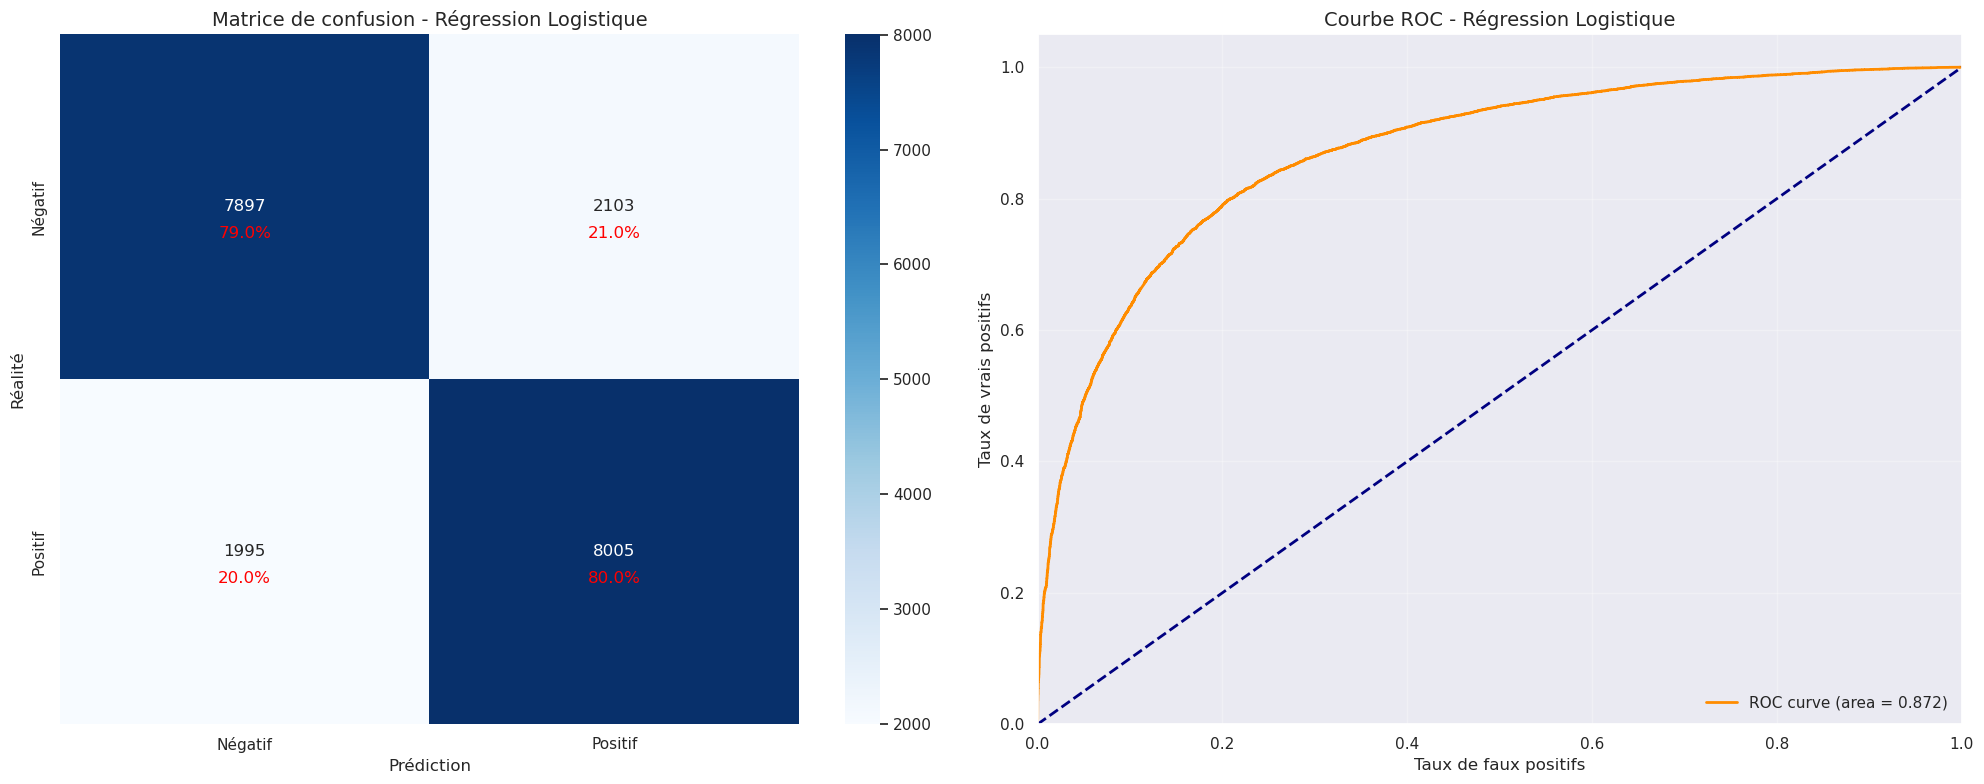

Visualisation combinée sauvegardée : visualisations/3_1_combined_results_régression_logistique.png
Résultats du modèle 'Régression Logistique' sauvegardés dans results/classical/Régression Logistique
Visualisations sauvegardées dans visualisations avec préfixe '3_1_'
Fonction train_evaluate_classical_model exécutée en 8.61 secondes

--------------------------------------------------



##### Entraînement du modèle: Naive Bayes


Résultats pour Naive Bayes:
Accuracy: 0.7726
Precision: 0.7730
Recall: 0.7726
F1 Score: 0.7726
ROC AUC: 0.8540
Temps d'entraînement: 1.26 secondes
Temps d'inférence total: 0.1921 secondes
Temps d'inférence par exemple: 0.0096 ms
Taille du modèle: 6.74 MB
Modèle sauvegardé: models/classical/naive_bayes.pkl


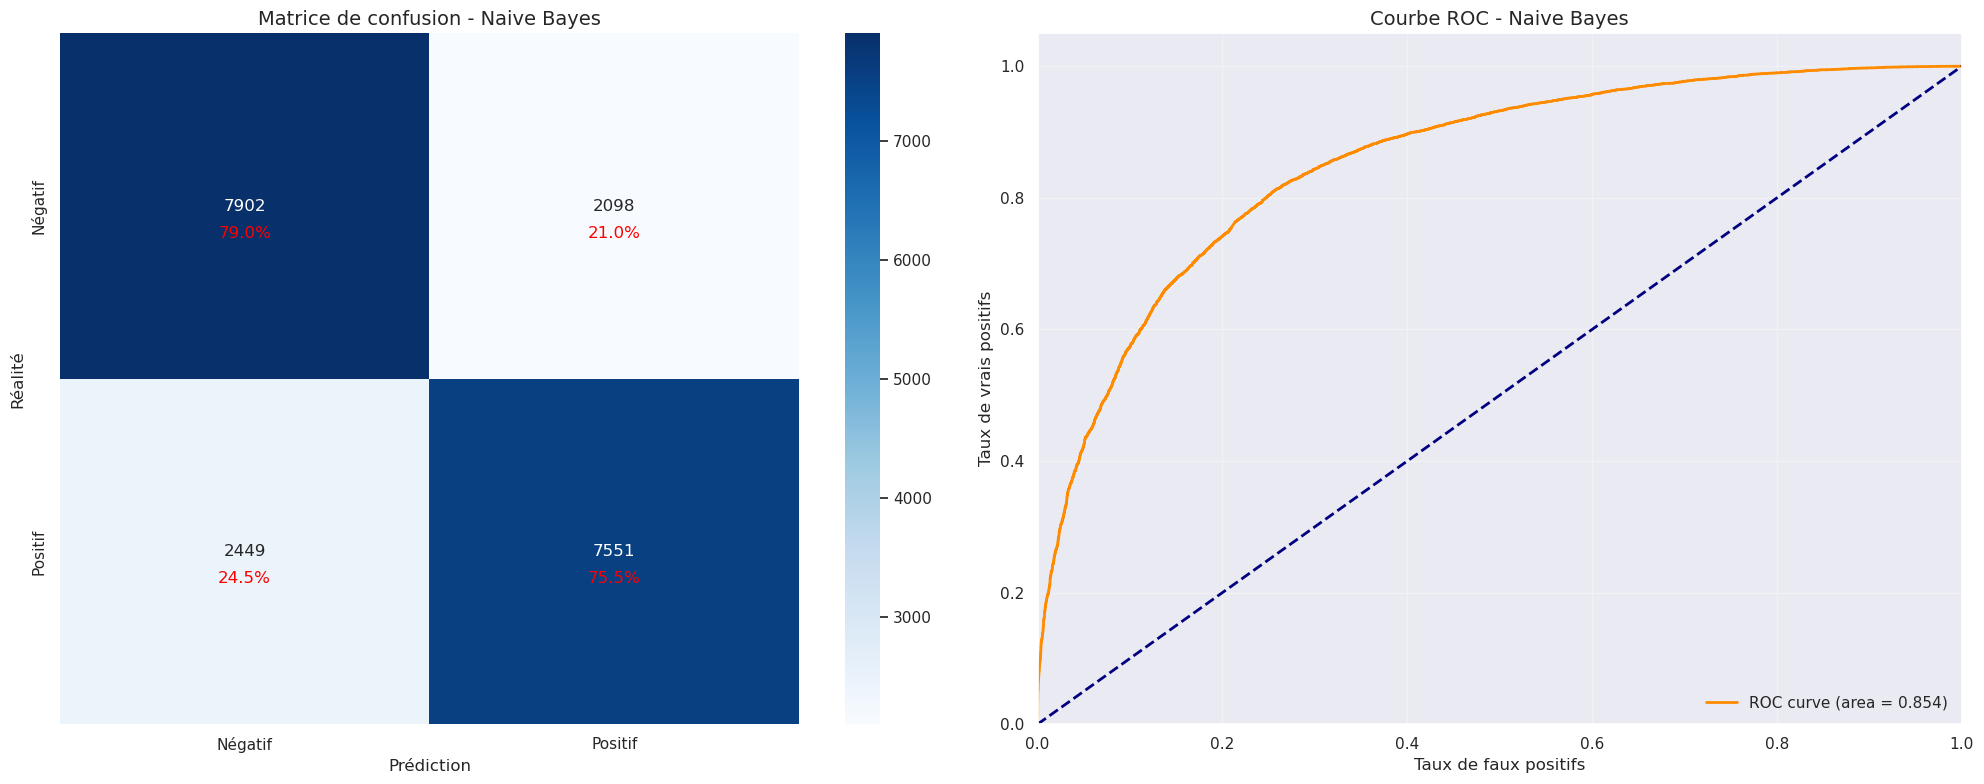

Visualisation combinée sauvegardée : visualisations/3_1_combined_results_naive_bayes.png
Résultats du modèle 'Naive Bayes' sauvegardés dans results/classical/Naive Bayes
Visualisations sauvegardées dans visualisations avec préfixe '3_1_'
Fonction train_evaluate_classical_model exécutée en 7.30 secondes

--------------------------------------------------



##### Entraînement du modèle: SVM Linéaire


Résultats pour SVM Linéaire:
Accuracy: 0.7787
Precision: 0.7787
Recall: 0.7787
F1 Score: 0.7787
Temps d'entraînement: 1.93 secondes
Temps d'inférence total: 0.1911 secondes
Temps d'inférence par exemple: 0.0096 ms
Taille du modèle: 6.08 MB
Modèle sauvegardé: models/classical/svm_linéaire.pkl
Résultats du modèle 'SVM Linéaire' sauvegardés dans results/classical/SVM Linéaire
Visualisations sauvegardées dans visualisations avec préfixe '3_1_'
Fonction train_evaluate_classical_model exécutée en 5.61 secondes

--------------------------------------------------



##### Entraînement du modèle: Random Forest


Résultats pour Random Forest:
Accuracy: 0.7378
Precision: 0.7393
Recall: 0.7378
F1 Score: 0.7373
ROC AUC: 0.8146
Temps d'entraînement: 1.86 secondes
Temps d'inférence total: 0.2555 secondes
Temps d'inférence par exemple: 0.0128 ms
Taille du modèle: 7.70 MB
Modèle sauvegardé: models/classical/random_forest.pkl


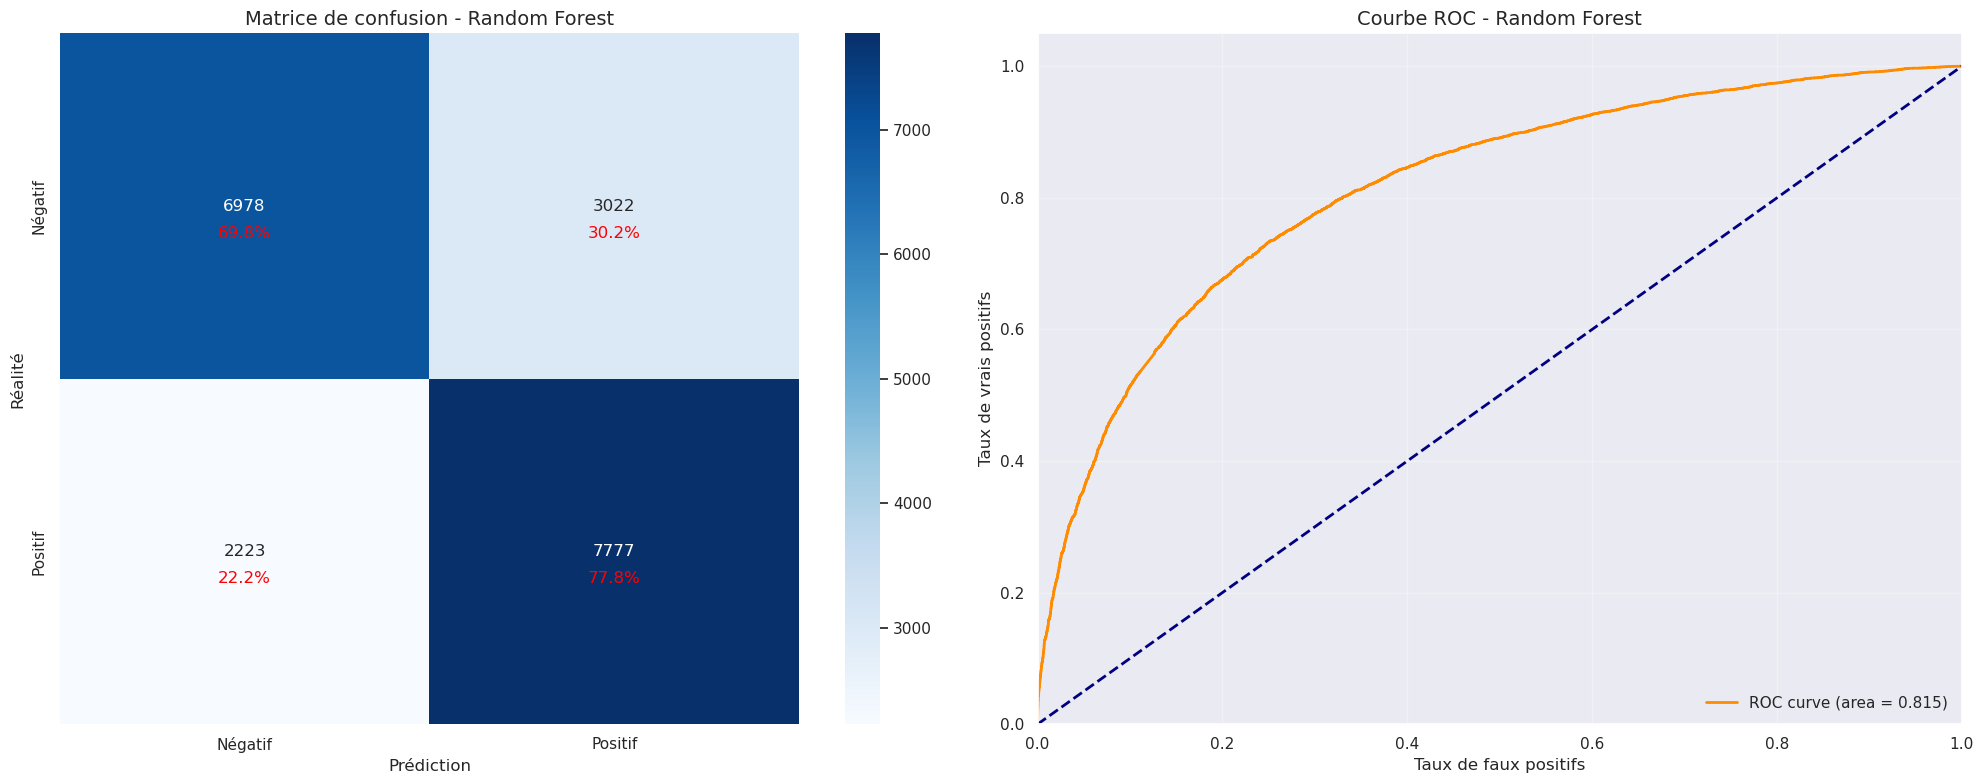

Visualisation combinée sauvegardée : visualisations/3_1_combined_results_random_forest.png
Résultats du modèle 'Random Forest' sauvegardés dans results/classical/Random Forest
Visualisations sauvegardées dans visualisations avec préfixe '3_1_'
Fonction train_evaluate_classical_model exécutée en 8.52 secondes

--------------------------------------------------

Résultats sauvegardés: results/classical/comparison.csv
Forme du DataFrame classical_results: (4, 11)


#### ====== Résultats des modèles classiques ======

,Modèle,Type,Accuracy,Precision,Recall,F1 Score,ROC AUC,Temps (s),Taille (MB),Inf. (s),Inf. (ms/ex)
0,Régression Logistique,Classique,0.79510,0.795134,0.79510,0.795094,0.871713,1.632005,6.083682,0.185595,0.009280
1,Naive Bayes,Classique,0.77265,0.772986,0.77265,0.772580,0.853955,1.258116,6.738239,0.192134,0.009607
2,SVM Linéaire,Classique,0.77870,0.778711,0.77870,0.778698,NaN,1.927610,6.083600,0.191098,0.009555
3,Random Forest,Classique,0.73775,0.739278,0.73775,0.737331,0.814624,1.862205,7.703179,0.255530,0.012776



#### ====== Comparaison des performances des modèles classiques ======

| Modèle | Accuracy | F1 Score | Temps (s) | Taille (MB) |
|--------|----------|----------|-----------|-------------|
| Régression Logistique | 0.7951 | 0.7951 | 1.63 | 6.08 |
| Naive Bayes | 0.7726 | 0.7726 | 1.26 | 6.74 |
| SVM Linéaire | 0.7787 | 0.7787 | 1.93 | 6.08 |
| Random Forest | 0.7378 | 0.7373 | 1.86 | 7.70 |


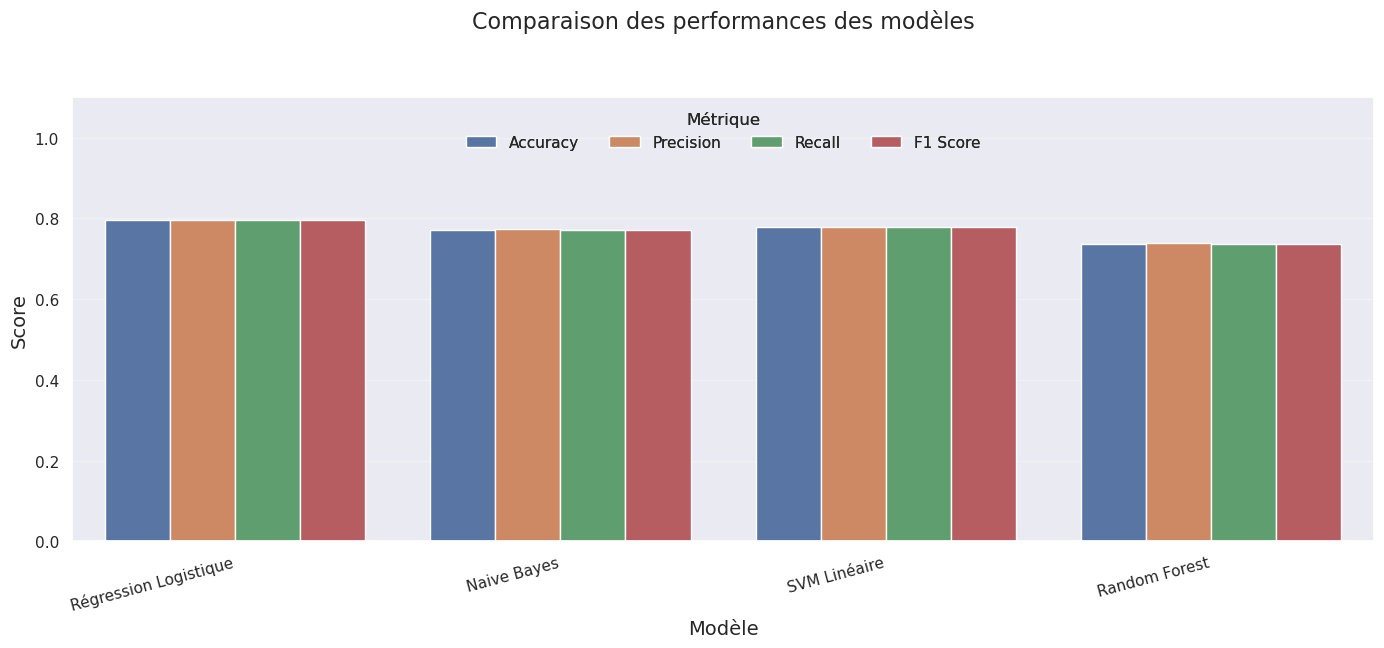

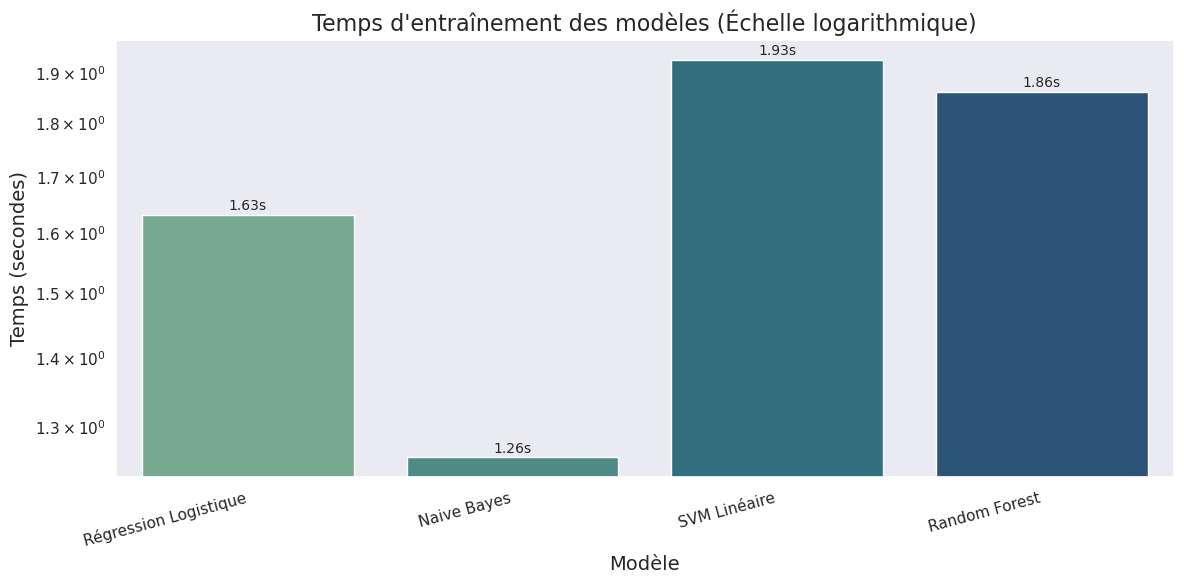

In [13]:
# 3.3 Exécution et visualisation des modèles classiques

from utils import train_evaluate_classical_model, train_all_classical_models, print_md

# from utils import train_evaluate_classical_model, train_all_classical_models, print_md
# from visualization_utils import plot_model_comparison, plot_model_time_comparison
# import pandas as pd
# import os

# Charger les données prétraitées
X_train, X_test, y_train, y_test = load_processed_data()

# Entraîner tous les modèles classiques
print_md("#### ====== Entraînement des modèles classiques ======")

classical_results = train_all_classical_models(X_train, X_test, y_train, y_test)
print(f"Forme du DataFrame classical_results: {classical_results.shape}")

# Afficher les résultats
print_md(f"""#### ====== Résultats des modèles classiques ======""")

display(classical_results)

print_md(f"""
#### ====== Comparaison des performances des modèles classiques ======

| Modèle | Accuracy | F1 Score | Temps (s) | Taille (MB) |
|--------|----------|----------|-----------|-------------|
| {classical_results.iloc[0]['Modèle']} | {classical_results.iloc[0]['Accuracy']:.4f} | {classical_results.iloc[0]['F1 Score']:.4f} | {classical_results.iloc[0]['Temps (s)']:.2f} | {classical_results.iloc[0]['Taille (MB)']:.2f} |
| {classical_results.iloc[1]['Modèle']} | {classical_results.iloc[1]['Accuracy']:.4f} | {classical_results.iloc[1]['F1 Score']:.4f} | {classical_results.iloc[1]['Temps (s)']:.2f} | {classical_results.iloc[1]['Taille (MB)']:.2f} |
| {classical_results.iloc[2]['Modèle']} | {classical_results.iloc[2]['Accuracy']:.4f} | {classical_results.iloc[2]['F1 Score']:.4f} | {classical_results.iloc[2]['Temps (s)']:.2f} | {classical_results.iloc[2]['Taille (MB)']:.2f} |
| {classical_results.iloc[3]['Modèle']} | {classical_results.iloc[3]['Accuracy']:.4f} | {classical_results.iloc[3]['F1 Score']:.4f} | {classical_results.iloc[3]['Temps (s)']:.2f} | {classical_results.iloc[3]['Taille (MB)']:.2f} |
""")

# Visualiser les performances des modèles
plot_model_comparison(classical_results, 
                      metrics=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                      filename='visualisations/3_3_classical_models_comparison.png')
plot_model_comparison(classical_results, 
                      metrics=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Visualiser les temps d'entraînement
plot_model_time_comparison(classical_results, 
                          filename='visualisations/3_3_classical_models_time_comparison.png')
plot_model_time_comparison(classical_results)

### 3.4 Analyse approfondie du meilleur modèle classique

Étude détaillée des features importantes et du comportement du modèle le plus performant.


Meilleur modèle classique: Régression Logistique



#### Features les plus importantes pour Régression Logistique

| Feature | Importance |
|---------|------------|
| sad | 10.3067 |
| miss | 8.4180 |
| cant wait | 7.3494 |
| cant | 6.7208 |
| poor | 6.5777 |
| wish | 6.3061 |
| sick | 6.2023 |
| hate | 5.9456 |
| bad | 5.4860 |
| lose | 5.3556 |



Top 20 des features les plus importantes:


,feature,importance
19498,sad,10.306672
14480,miss,8.417996
4127,cant wait,7.349394
4056,cant,6.720822
18351,poor,6.577650
27278,wish,6.306064
20293,sick,6.202267
9408,hate,5.945636
1924,bad,5.486021
13527,lose,5.355593


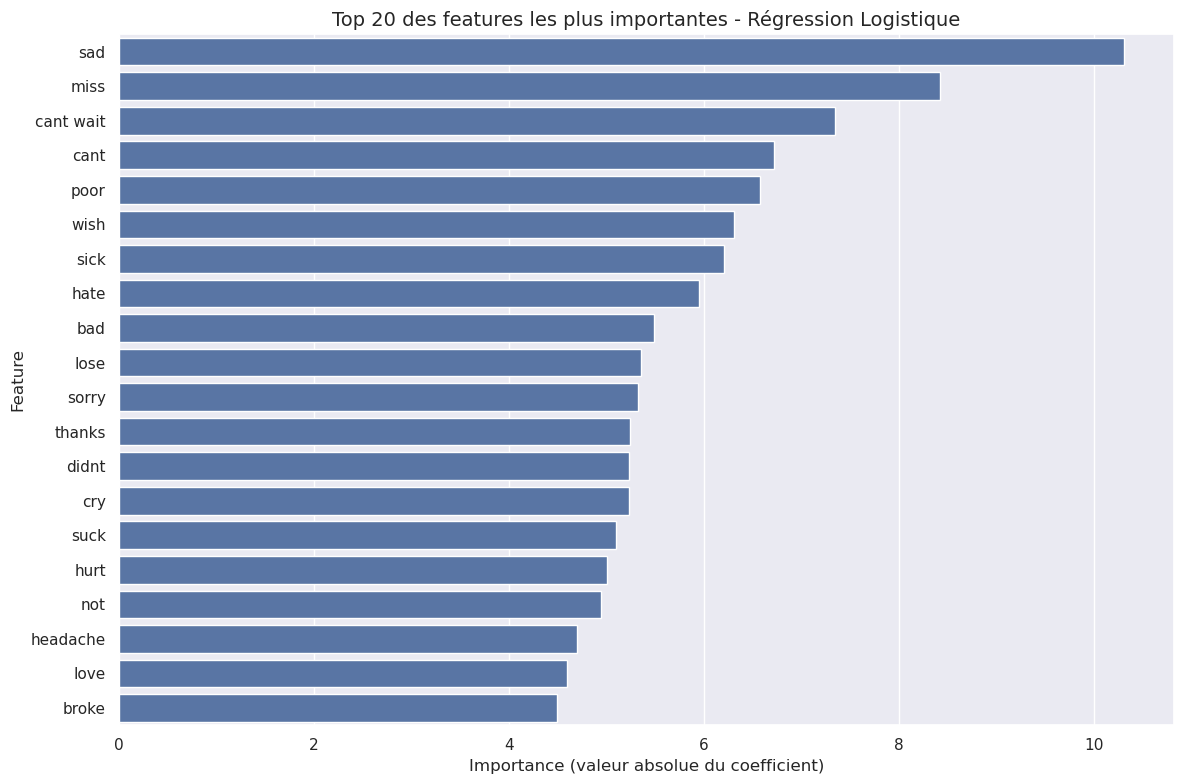

In [14]:
# 3.4 Analyse approfondie du meilleur modèle classique
# Trouver le meilleur modèle selon le F1 Score
best_model_idx = classical_results['F1 Score'].idxmax()
best_model_name = classical_results.loc[best_model_idx, 'Modèle']
print(f"\nMeilleur modèle classique: {best_model_name}")

# Charger le meilleur modèle
best_model_path = f"models/classical/{best_model_name.replace(' ', '_').lower()}.pkl"
with open(best_model_path, 'rb') as f:
    best_pipeline = pickle.load(f)

# Accéder au vectoriseur et au modèle
vectorizer = best_pipeline.named_steps['vectorizer']
model = best_pipeline.named_steps['model']

features_md = f"""
#### Features les plus importantes pour {best_model_name}

| Feature | Importance |
|---------|------------|
"""

# Analyse des features importantes (pour les modèles qui le supportent)
if hasattr(model, 'coef_'):
    feature_names = vectorizer.get_feature_names_out()
    
    # Pour les modèles avec une seule classe de sortie (ex: LogisticRegression avec deux classes)
    if len(model.coef_.shape) == 2 and model.coef_.shape[0] == 1:
        coefficients = model.coef_[0]
    else:
        coefficients = model.coef_
    
    # Créer un DataFrame avec les coefficients
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(coefficients)
    })
    
    # Trier par importance décroissante
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    for i in range(min(10, len(feature_importance))):
        row = feature_importance.iloc[i]
        feat = row.get('feature')  # Utilisation de get() pour éviter les erreurs
        imp = row.get('importance')
        features_md += f"| {feat} | {imp:.4f} |\n"
    print_md(features_md)
    
    # Afficher les 20 features les plus importantes
    print("\nTop 20 des features les plus importantes:")
    display(feature_importance.head(20))

    # Visualiser les 20 features les plus importantes
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title(f'Top 20 des features les plus importantes - {best_model_name}', fontsize=14)
    plt.xlabel('Importance (valeur absolue du coefficient)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(f'visualisations/3_4_feature_importance_{best_model_name.replace(" ", "_").lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
elif hasattr(model, 'feature_importances_'):
    # Pour les modèles comme Random Forest
    feature_names = vectorizer.get_feature_names_out()
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    
    # Trier par importance décroissante
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    # Afficher les 20 features les plus importantes
    print("\nTop 20 des features les plus importantes:")
    display(feature_importance.head(20))

    
    # Visualiser les 20 features les plus importantes
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(20))
    plt.title(f'Top 20 des features les plus importantes - {best_model_name}', fontsize=14)
    plt.xlabel('Importance de la feature')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(f'visualisations/3_4_feature_importance_{best_model_name.replace(" ", "_").lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print(f"L'extraction des features importantes n'est pas supportée pour le modèle {best_model_name}")

### 3.5 Échantillons de prédictions

Tests du modèle sur des exemples concrets de tweets pour évaluer qualitativement ses performances.

In [15]:
# 3.5 Échantillons de prédictions
# Faire des prédictions sur quelques exemples
sample_texts = [
    "I absolutely love this product! It's amazing!",
    "This is the worst experience I've ever had.",
    "The flight was delayed by 2 hours and no compensation was offered.",
    "Air Paradis has the best customer service I've experienced.",
    "Not sure how I feel about this, it's just okay I guess."
]

# Nettoyer les textes
sample_cleaned = [clean_text(text) for text in sample_texts]

# Faire les prédictions
sample_predictions = best_pipeline.predict(sample_cleaned)
if hasattr(best_pipeline, 'predict_proba'):
    sample_proba = best_pipeline.predict_proba(sample_cleaned)[:, 1]
else:
    sample_proba = None

predictions_md = f"""
#### Exemples de prédictions avec {best_model_name}

| Texte | Prédiction | Confiance |
|-------|------------|-----------|
"""

for i, (text, pred) in enumerate(zip(sample_texts, sample_predictions)):
    sentiment = "Positif" if pred == 1 else "Négatif"
    confidence = sample_proba[i] if sample_proba is not None else "N/A"
    predictions_md += f"| {text} | {sentiment} | {confidence:.2f} |\n"

print_md(predictions_md)


#### Exemples de prédictions avec Régression Logistique

| Texte | Prédiction | Confiance |
|-------|------------|-----------|
| I absolutely love this product! It's amazing! | Positif | 0.91 |
| This is the worst experience I've ever had. | Positif | 0.66 |
| The flight was delayed by 2 hours and no compensation was offered. | Négatif | 0.10 |
| Air Paradis has the best customer service I've experienced. | Positif | 0.75 |
| Not sure how I feel about this, it's just okay I guess. | Négatif | 0.31 |


### 3.6 Conclusion sur les modèles classiques

In [16]:
# 3.6 Conclusion sur les modèles classiques

print_md( f"""
Le meilleur modèle classique est **{best_model_name}** avec:
- F1 Score: **{classical_results.loc[best_model_idx, 'F1 Score']:.4f}**
- Temps d'entraînement: **{classical_results.loc[best_model_idx, 'Temps (s)']:.2f} secondes**
- Taille du modèle: **{classical_results.loc[best_model_idx, 'Taille (MB)']:.2f} MB**

**Avantages des modèles classiques:**
- Rapides à entraîner
- Facilement interprétables
- Taille réduite facilitant le déploiement

**Limites des modèles classiques:**
- Ne capturent pas la sémantique complexe des textes
- Performances limitées par rapport aux approches avancées
- Ne prennent pas en compte l'ordre des mots et le contexte
""" )


Le meilleur modèle classique est **Régression Logistique** avec:
- F1 Score: **0.7951**
- Temps d'entraînement: **1.63 secondes**
- Taille du modèle: **6.08 MB**

**Avantages des modèles classiques:**
- Rapides à entraîner
- Facilement interprétables
- Taille réduite facilitant le déploiement

**Limites des modèles classiques:**
- Ne capturent pas la sémantique complexe des textes
- Performances limitées par rapport aux approches avancées
- Ne prennent pas en compte l'ordre des mots et le contexte


## 4. Modèles Deep Learning ("Modèle sur mesure avancé")

Dans cette section, nous allons développer des modèles de deep learning plus sophistiqués pour l'analyse de sentiment des tweets. Ces modèles ont la capacité de capturer des relations complexes dans le texte grâce à différentes architectures neuronales.

### 4.1 Préparation des données pour les modèles deep learning

Les modèles de deep learning nécessitent une préparation spécifique des données textuelles, notamment la conversion en séquences numériques et le padding pour obtenir des longueurs uniformes.

In [17]:
# 4. Modèles Deep Learning ("Modèle sur mesure avancé")
# 4.1 Préparation des données pour les modèles deep learning

from utils import prepare_data_for_dl

### 4.2 Chargement des embeddings pré-entrainés

Pour représenter efficacement les mots, nous utiliserons des embeddings pré-entraînés GloVe qui capturent la sémantique des mots dans un espace vectoriel. Ces embeddings peuvent améliorer significativement les performances des modèles de deep learning.

In [18]:
# 4.2 Chargement des embeddings pré-entrainés

from utils import load_glove_embeddings, create_random_embeddings


### 4.3 Fonctions pour les modèles de deep learning

Nous définissons ici les fonctions nécessaires pour l'entraînement et l'évaluation des modèles deep learning, incluant les callbacks personnalisés et les métriques d'évaluation.

### 4.4 Définition des architectures de modèles deep learning

Nous implémentons deux architectures principales :
- **CNN (Convolutional Neural Networks)** : Efficaces pour capturer les motifs locaux dans le texte
- **LSTM (Long Short-Term Memory)** : Spécialisés dans la modélisation des dépendances séquentielles à long terme

Chaque architecture sera testée avec deux types d'embeddings : entraînables et pré-entraînés (GloVe).

In [19]:
# 4.3 Fonctions pour les modèles de deep learning

from utils import get_callbacks, train_evaluate_dl_model

In [20]:
# 4.4 Définition des architectures de modèles deep learning

# Ces modèles sont maintenant définis dans utils.py pour faciliter leur réutilisation
from utils import create_cnn_model, create_lstm_model

"""
Cette section utilise deux architectures principales:
- CNN (Convolutional Neural Networks) pour capturer les motifs locaux dans le texte
- LSTM (Long Short-Term Memory) pour modéliser les dépendances séquentielles à long terme

Chaque architecture est testée avec deux types d'embeddings: entraînables et pré-entraînés (GloVe).
"""

"\nCette section utilise deux architectures principales:\n- CNN (Convolutional Neural Networks) pour capturer les motifs locaux dans le texte\n- LSTM (Long Short-Term Memory) pour modéliser les dépendances séquentielles à long terme\n\nChaque architecture est testée avec deux types d'embeddings: entraînables et pré-entraînés (GloVe).\n"

### 4.5 Entraînement et évaluation des modèles deep learning

Cette fonction orchestre l'entraînement de tous les modèles deep learning définis précédemment, avec différentes configurations d'embeddings. Nous collectons systématiquement les métriques de performance, les temps d'exécution et les tailles des modèles pour une comparaison objective.

In [21]:
# 4.5 Entraînement et évaluation des modèles deep learning

# Ces modèles sont maintenant définis dans utils.py pour faciliter leur réutilisation
from utils import apply_augmentation
from utils import train_all_dl_models



### 4.6 Exécution et visualisation des modèles deep learning

Les graphiques ci-dessous présentent une comparaison des performances (F1 Score, Accuracy, etc.) et des ressources requises (temps d'entraînement, taille des modèles) pour les différentes architectures testées.

#### ====== Entraînement des modèles deep learning ======

Préparation des données pour les modèles DL (vocab=50000, seq_len=100)...
Taille du vocabulaire: 49502
Forme de X_train_seq: (80000, 100)
Forme de X_test_seq: (20000, 100)
Tokenizer sauvegardé: models/deeplearning/tokenizer.pkl
Fonction prepare_data_for_dl exécutée en 1.42 secondes
Données d'entraînement augmentées: 80000 → 93201 séquences
Chargement des embeddings GloVe (dim=100)...
Taille du vocabulaire configurée: 49502
Archive GloVe déjà téléchargée: data/glove.6B.zip
Extraction des fichiers GloVe...
Extraction terminée.
Création d'embeddings aléatoires...
Matrice d'embeddings aléatoires sauvegardée: models/deeplearning/random_100d_embedding.npy
Fonction load_glove_embeddings exécutée en 10.44 secondes
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           2475100   
                                                                 



--------------------------------------------------

##### Entraînement du modèle: CNN (embeddings entraînables)

--------------------------------------------------



--------------------------------------------------
Entraînement du modèle: CNN (embeddings entraînables)
--------------------------------------------------

Entraînement du modèle: CNN (embeddings entraînables)
Epoch 1/10


I0000 00:00:1747644809.292511  750714 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1238/1238 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.6138
Epoch 1: val_loss improved from inf to 1.24216, saving model to models/checkpoints/CNN (embeddings entraînables).keras
1238/1238 [==============================] - 9s 5ms/step - loss: 0.7018 - accuracy: 0.6138 - val_loss: 1.2422 - val_accuracy: 0.6541 - lr: 5.0000e-04
Epoch 2/10
1231/1238 [============================>.] - ETA: 0s - loss: 0.4954 - accuracy: 0.7769
Epoch 2: val_loss improved from 1.24216 to 0.92365, saving model to models/checkpoints/CNN (embeddings entraînables).keras
1238/1238 [==============================] - 6s 5ms/step - loss: 0.4957 - accuracy: 0.7767 - val_loss: 0.9236 - val_accuracy: 0.7253 - lr: 5.0000e-04
Epoch 3/10
1235/1238 [============================>.] - ETA: 0s - loss: 0.4131 - accuracy: 0.8288
Epoch 3: val_loss improved from 0.92365 to 0.76799, saving model to models/checkpoints/CNN (embeddings entraînables).keras
1238/1238 [==============================] - 6s 5ms/

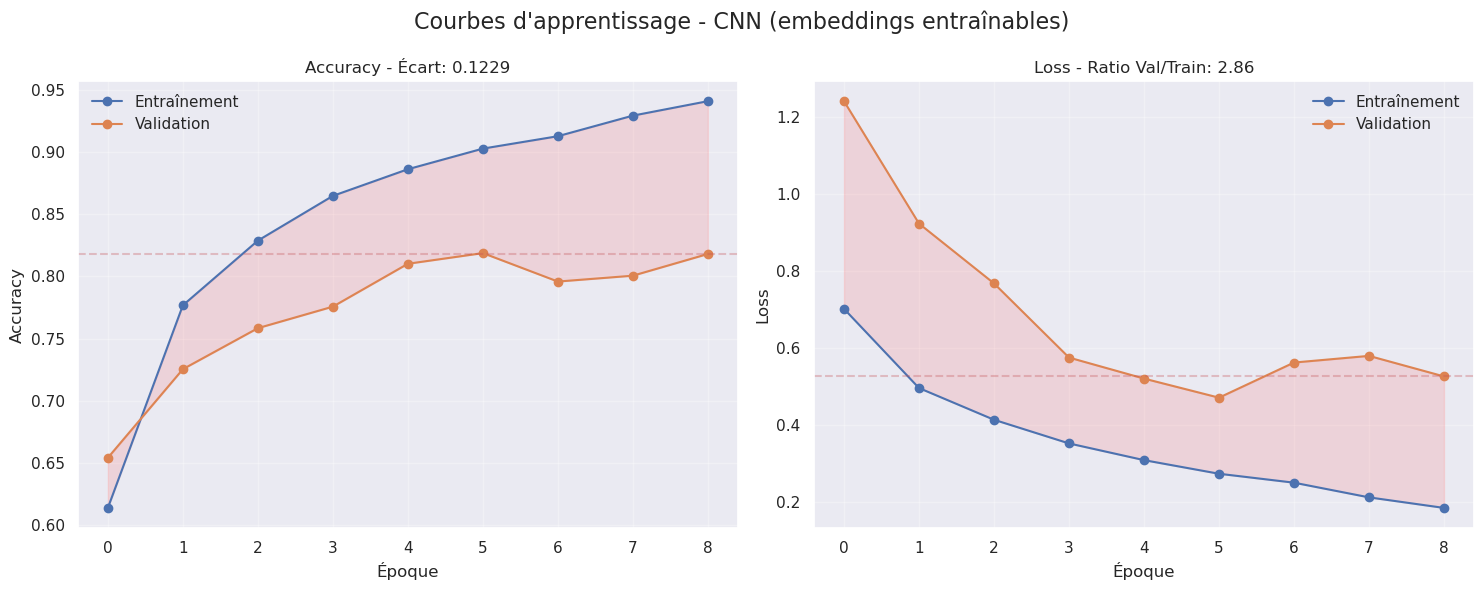

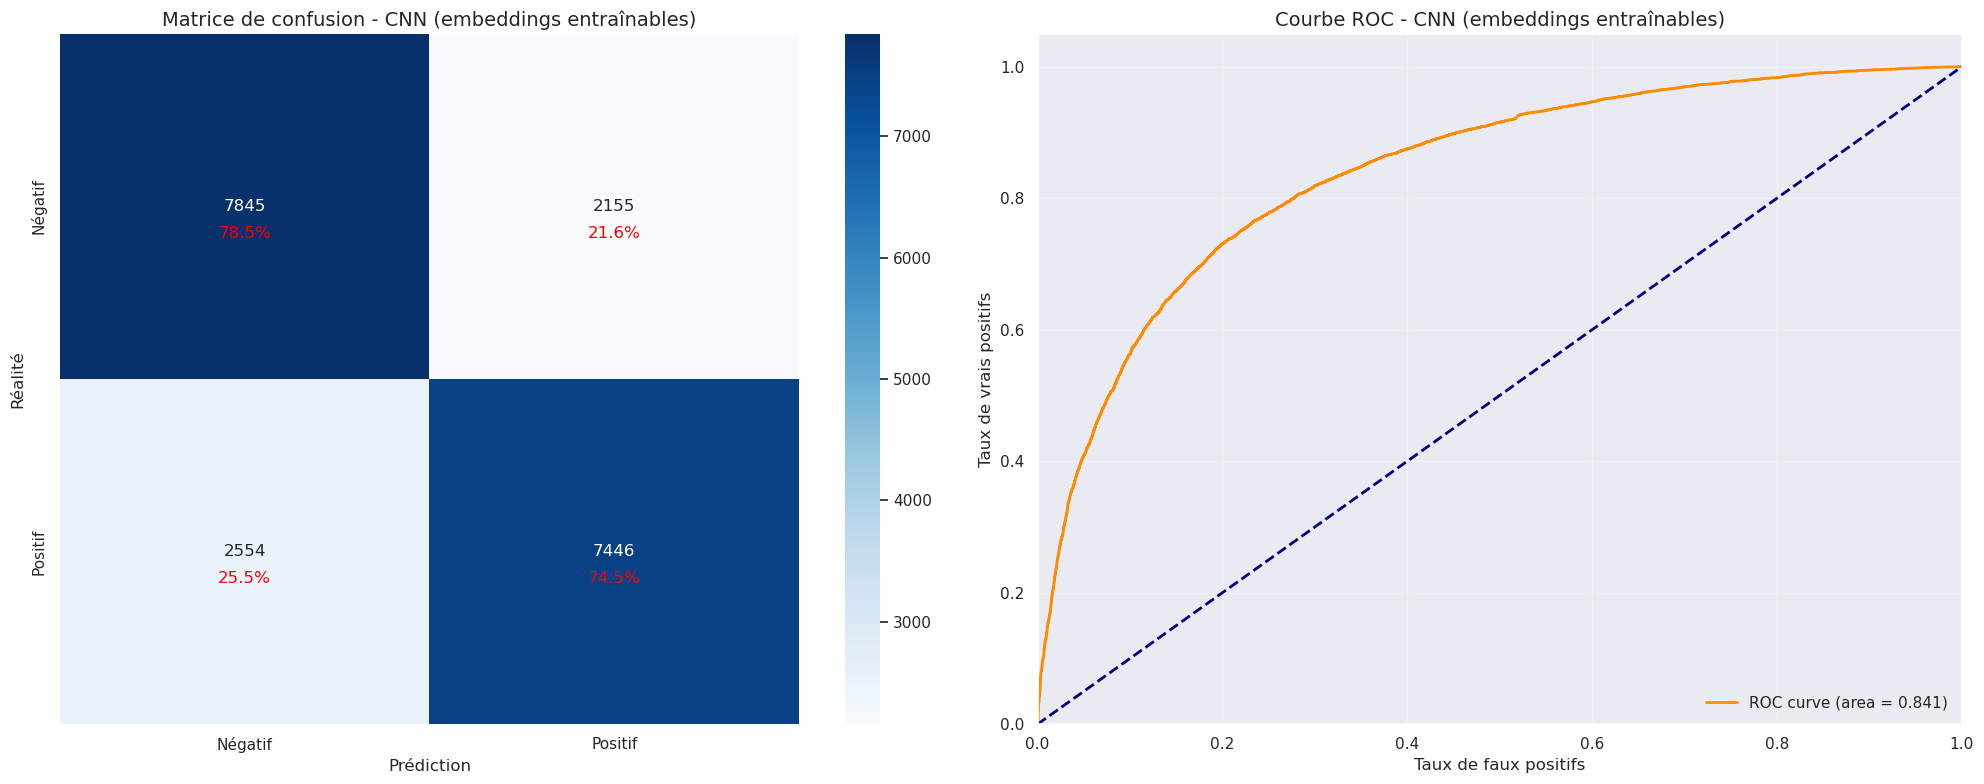

Visualisation combinée sauvegardée : visualisations/4_3_combined_results_cnn_(embeddings_entraînables).png
Résultats du modèle 'CNN (embeddings entraînables)' sauvegardés dans results/deeplearning/CNN (embeddings entraînables)
Visualisations sauvegardées dans visualisations avec préfixe '4_3_'
INFO:tensorflow:Assets written to: /tmp/tmpmcqehhsw/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpmcqehhsw/model/data/model/assets
2025/05/19 10:54:42 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Fonction train_evaluate_dl_model exécutée en 75.56 secondes

--------------------------------------------------

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          4950200   
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 64)            32064     
                                                                 
 batch_normalization_3 (Bat  (None, 96, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 32, 64)            0         
 g1D)                                                            
       


--------------------------------------------------

##### Entraînement du modèle: CNN (GloVe)

--------------------------------------------------



--------------------------------------------------
Entraînement du modèle: CNN (GloVe)
--------------------------------------------------

Entraînement du modèle: CNN (GloVe)
Epoch 1/10
1238/1238 [==============================] - ETA: 0s - loss: 0.7731 - accuracy: 0.5458
Epoch 1: val_loss improved from inf to 0.66656, saving model to models/checkpoints/CNN (GloVe).keras
1238/1238 [==============================] - 7s 5ms/step - loss: 0.7731 - accuracy: 0.5458 - val_loss: 0.6666 - val_accuracy: 0.6186 - lr: 5.0000e-04
Epoch 2/10
1226/1238 [============================>.] - ETA: 0s - loss: 0.6641 - accuracy: 0.6229
Epoch 2: val_loss improved from 0.66656 to 0.62935, saving model to models/checkpoints/CNN (GloVe).keras
1238/1238 [==============================] - 6s 5ms/step - loss: 0.6638 - accuracy: 0.6235 - val_loss: 0.6293 - val_accuracy: 0.6583 - lr: 5.0000e-04
Epoch 3/10
1232/1238 [============================>.] - ETA: 0s - loss: 0.6324 - accuracy: 0.6579
Epoch 3: val_loss improv

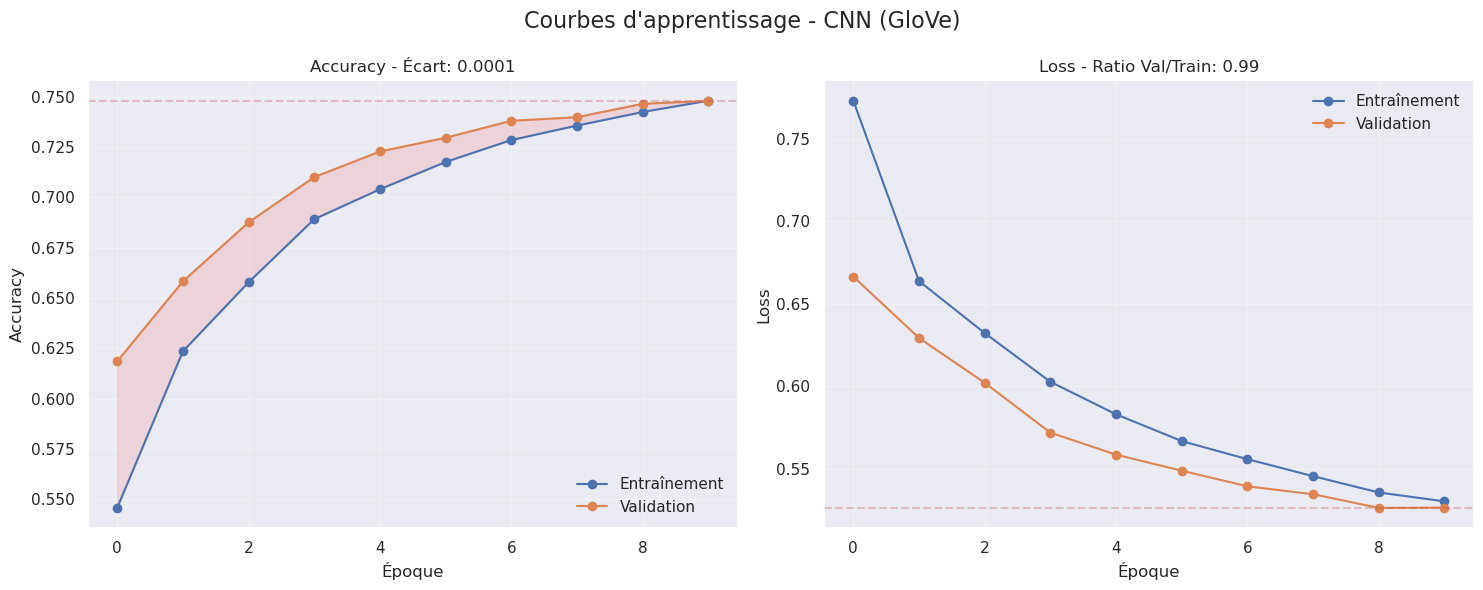

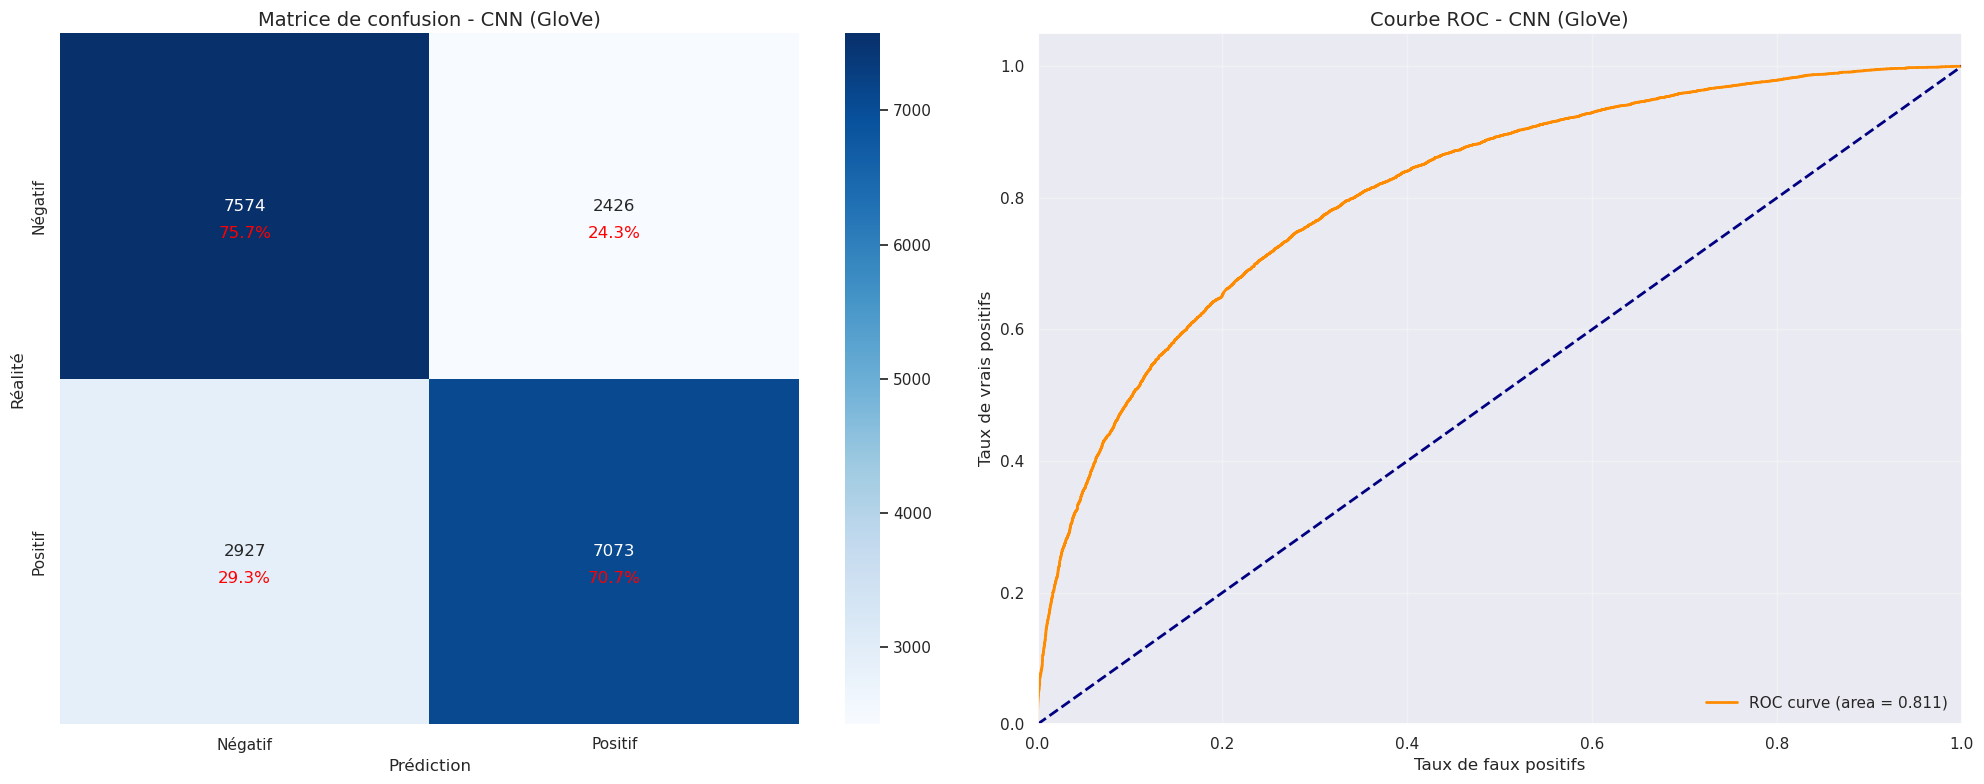

Visualisation combinée sauvegardée : visualisations/4_3_combined_results_cnn_(glove).png
Résultats du modèle 'CNN (GloVe)' sauvegardés dans results/deeplearning/CNN (GloVe)
Visualisations sauvegardées dans visualisations avec préfixe '4_3_'
INFO:tensorflow:Assets written to: /tmp/tmpeexkaqfb/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpeexkaqfb/model/data/model/assets
2025/05/19 10:55:57 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Fonction train_evaluate_dl_model exécutée en 74.40 secondes

--------------------------------------------------

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          4950200   
                                                                 
 bidirectional (Bidirection  (None, 100, 48)           24000     
 al)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 100, 48)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 24)                5856      
 onal)                                                           
                                                                 
 batch_normalization_6 (Bat  (None, 24)                96        
 chNorm


--------------------------------------------------

##### Entraînement du modèle: LSTM (embeddings entraînables)

--------------------------------------------------



--------------------------------------------------
Entraînement du modèle: LSTM (embeddings entraînables)
--------------------------------------------------

Entraînement du modèle: LSTM (embeddings entraînables)
Epoch 1/15
2474/2476 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5963
Epoch 1: val_loss improved from inf to 0.55777, saving model to models/checkpoints/LSTM (embeddings entraînables).keras
2476/2476 [==============================] - 46s 17ms/step - loss: 0.6933 - accuracy: 0.5964 - val_loss: 0.5578 - val_accuracy: 0.7567 - lr: 2.0000e-04
Epoch 2/15
2474/2476 [============================>.] - ETA: 0s - loss: 0.5907 - accuracy: 0.7175
Epoch 2: val_loss improved from 0.55777 to 0.51404, saving model to models/checkpoints/LSTM (embeddings entraînables).keras
2476/2476 [==============================] - 43s 17ms/step - loss: 0.5908 - accuracy: 0.7175 - val_loss: 0.5140 - val_accuracy: 0.7812 - lr: 2.0000e-04
Epoch 3/15
2475/2476 [====================

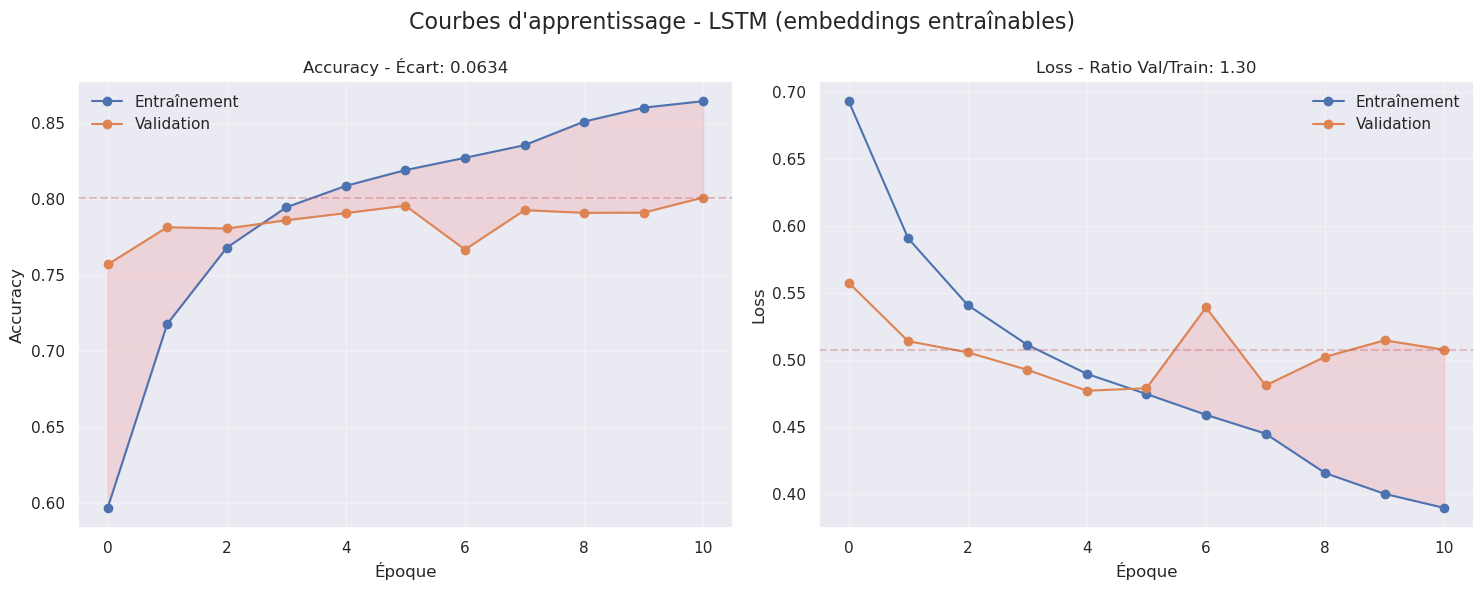

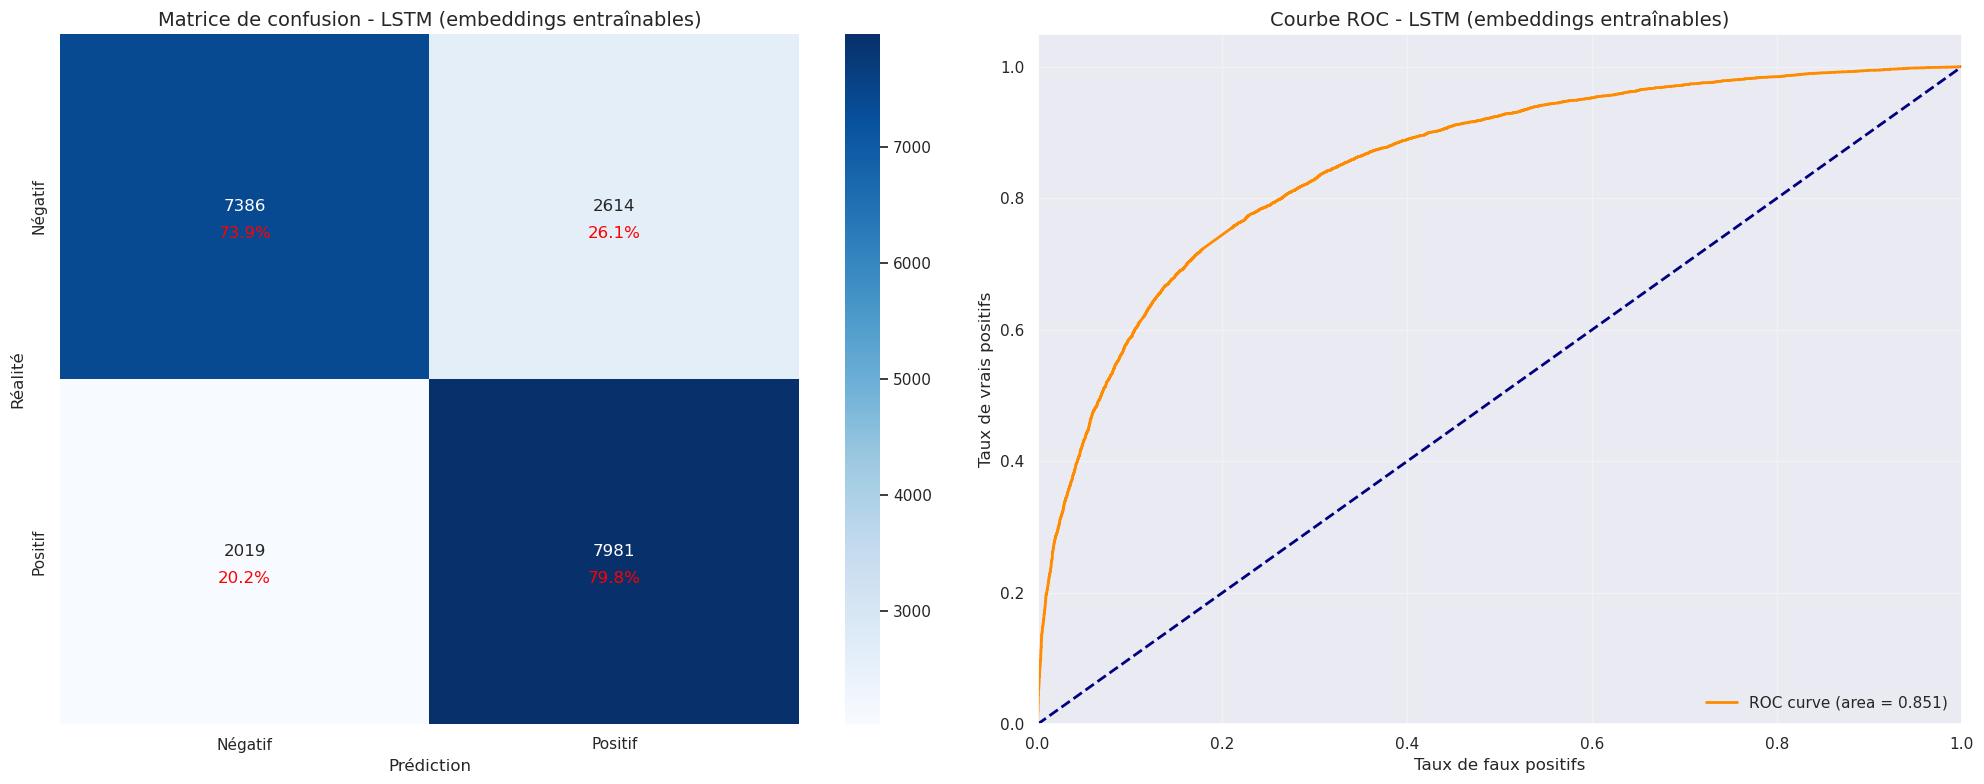

Visualisation combinée sauvegardée : visualisations/4_3_combined_results_lstm_(embeddings_entraînables).png
Résultats du modèle 'LSTM (embeddings entraînables)' sauvegardés dans results/deeplearning/LSTM (embeddings entraînables)
Visualisations sauvegardées dans visualisations avec préfixe '4_3_'
INFO:tensorflow:Assets written to: /tmp/tmpaki68jaf/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpaki68jaf/model/data/model/assets
2025/05/19 11:04:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Fonction train_evaluate_dl_model exécutée en 512.98 secondes

--------------------------------------------------

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          4950200   
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 112)          70336     
 onal)                                                           
                                                                 
 dropout_8 (Dropout)         (None, 100, 112)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                37120     
 onal)                                                           
                                                                 
 batch_normalization_7 (Bat  (None, 64)                256       
 chNor


--------------------------------------------------

##### Entraînement du modèle: LSTM (GloVe)

--------------------------------------------------



--------------------------------------------------
Entraînement du modèle: LSTM (GloVe)
--------------------------------------------------

Entraînement du modèle: LSTM (GloVe)
Epoch 1/15
2472/2476 [============================>.] - ETA: 0s - loss: 0.6570 - accuracy: 0.6222
Epoch 1: val_loss improved from inf to 0.61555, saving model to models/checkpoints/LSTM (GloVe).keras
2476/2476 [==============================] - 44s 16ms/step - loss: 0.6570 - accuracy: 0.6222 - val_loss: 0.6155 - val_accuracy: 0.6675 - lr: 5.0000e-04
Epoch 2/15
2476/2476 [==============================] - ETA: 0s - loss: 0.6021 - accuracy: 0.6857
Epoch 2: val_loss did not improve from 0.61555
2476/2476 [==============================] - 40s 16ms/step - loss: 0.6021 - accuracy: 0.6857 - val_loss: 0.7506 - val_accuracy: 0.5874 - lr: 5.0000e-04
Epoch 3/15
2476/2476 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.7192
Epoch 3: val_loss improved from 0.61555 to 0.57947, saving model to models/

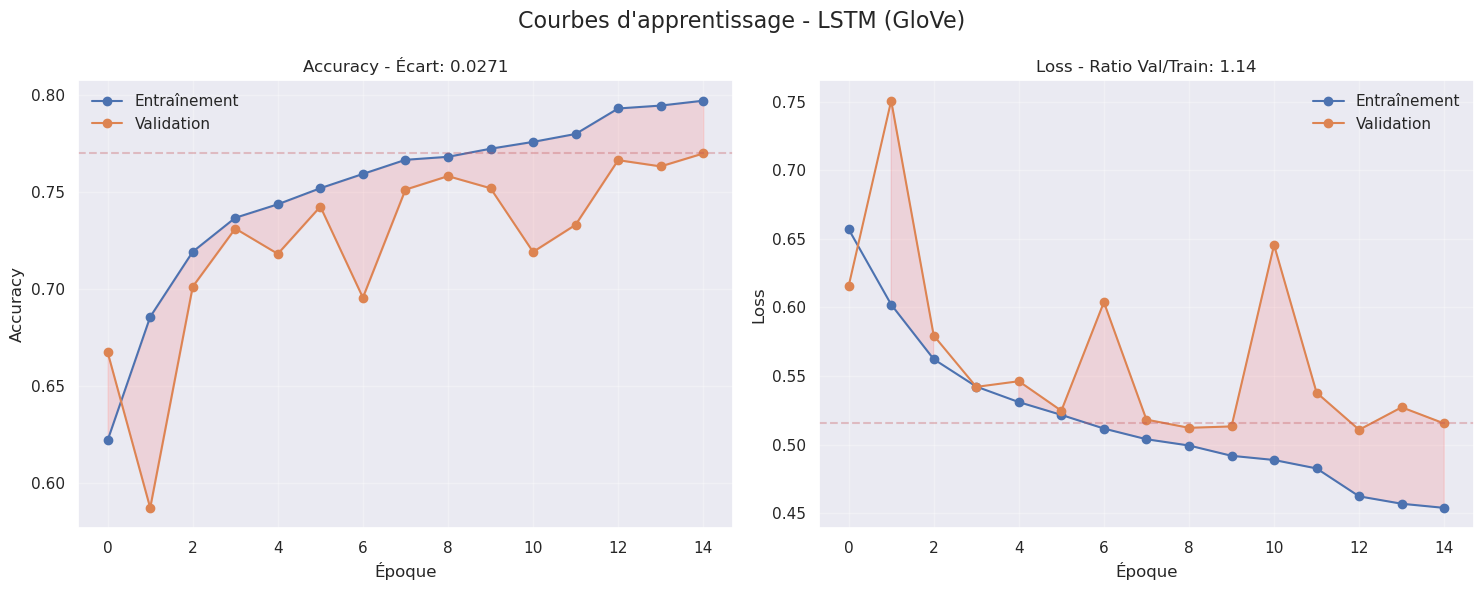

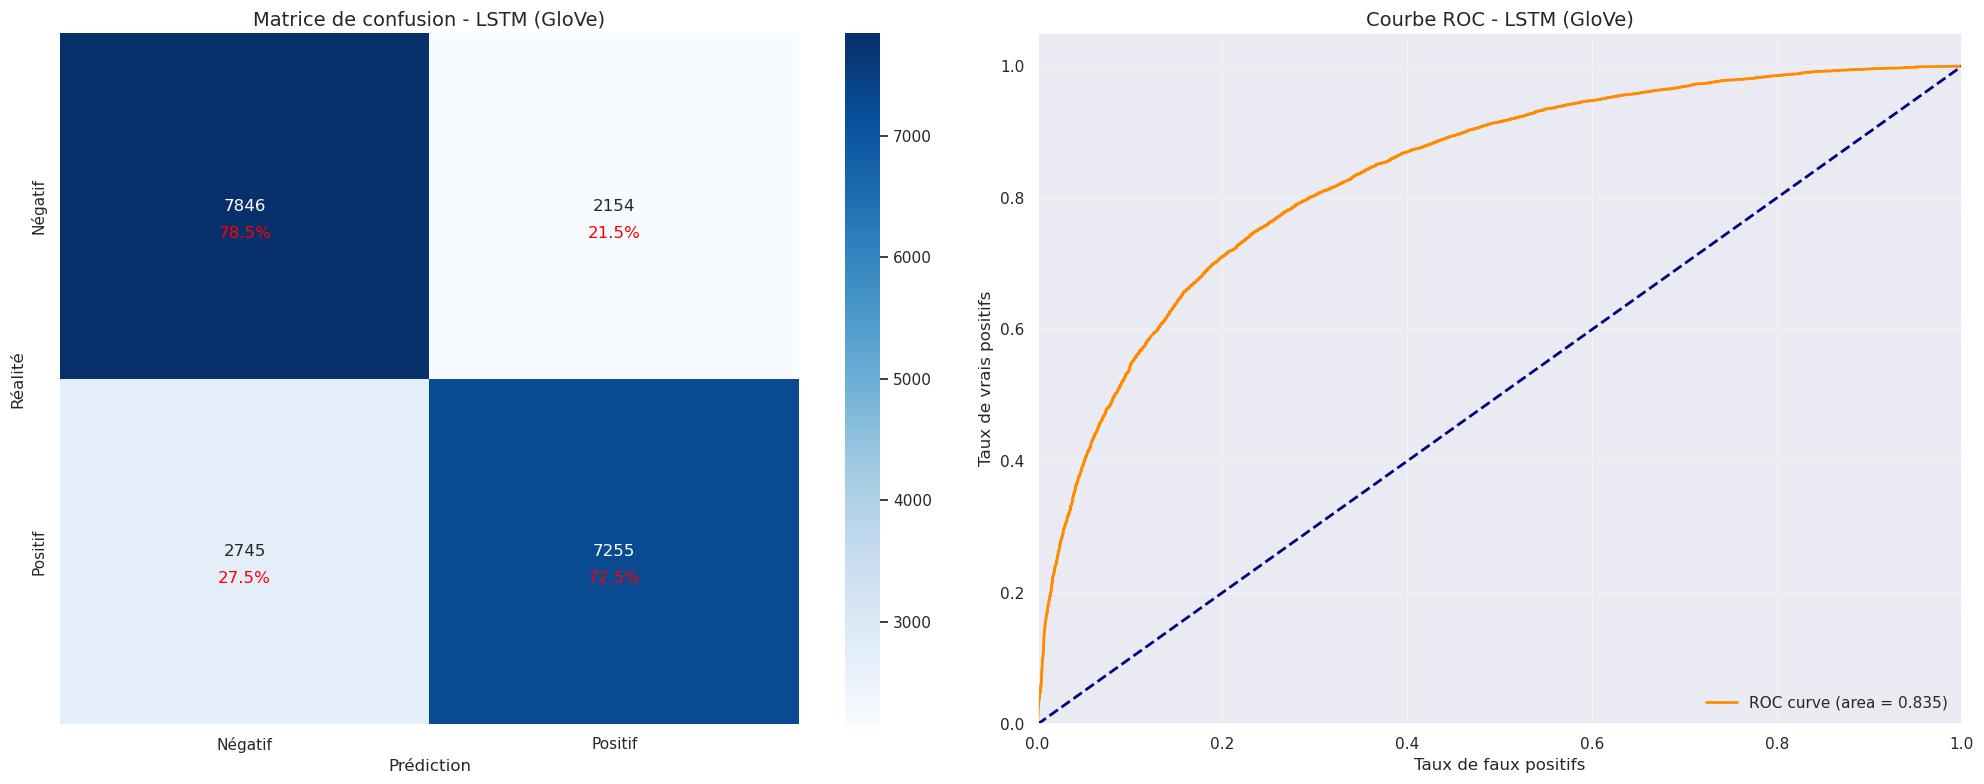

Visualisation combinée sauvegardée : visualisations/4_3_combined_results_lstm_(glove).png
Résultats du modèle 'LSTM (GloVe)' sauvegardés dans results/deeplearning/LSTM (GloVe)
Visualisations sauvegardées dans visualisations avec préfixe '4_3_'
INFO:tensorflow:Assets written to: /tmp/tmp_az9u5ne/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp_az9u5ne/model/data/model/assets
2025/05/19 11:15:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.0+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.1.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Fonction train_evaluate_dl_model exécutée en 649.36 secondes

--------------------------------------------------

Résultats sauvegardés: results/deeplearning/comparison.csv


#### ====== Résultats des modèles deep learning ======

,Modèle,Type,Accuracy,Precision,Recall,F1 Score,ROC AUC,Temps (s),Inf. (s),Inf. (ms/ex),Taille (MB)
0,CNN (embeddings entraînables),Deep Learning,0.76455,0.764972,0.76455,0.764456,0.840605,59.406440,0.577609,0.028880,28.667074
1,CNN (GloVe),Deep Learning,0.73235,0.732935,0.73235,0.732182,0.811362,59.218931,0.603432,0.030172,19.407817
2,LSTM (embeddings entraînables),Deep Learning,0.76835,0.769303,0.76835,0.768145,0.851303,467.294017,3.577341,0.178867,57.078356
3,LSTM (GloVe),Deep Learning,0.75505,0.755944,0.75505,0.754836,0.835200,603.749605,3.627526,0.181376,20.225370


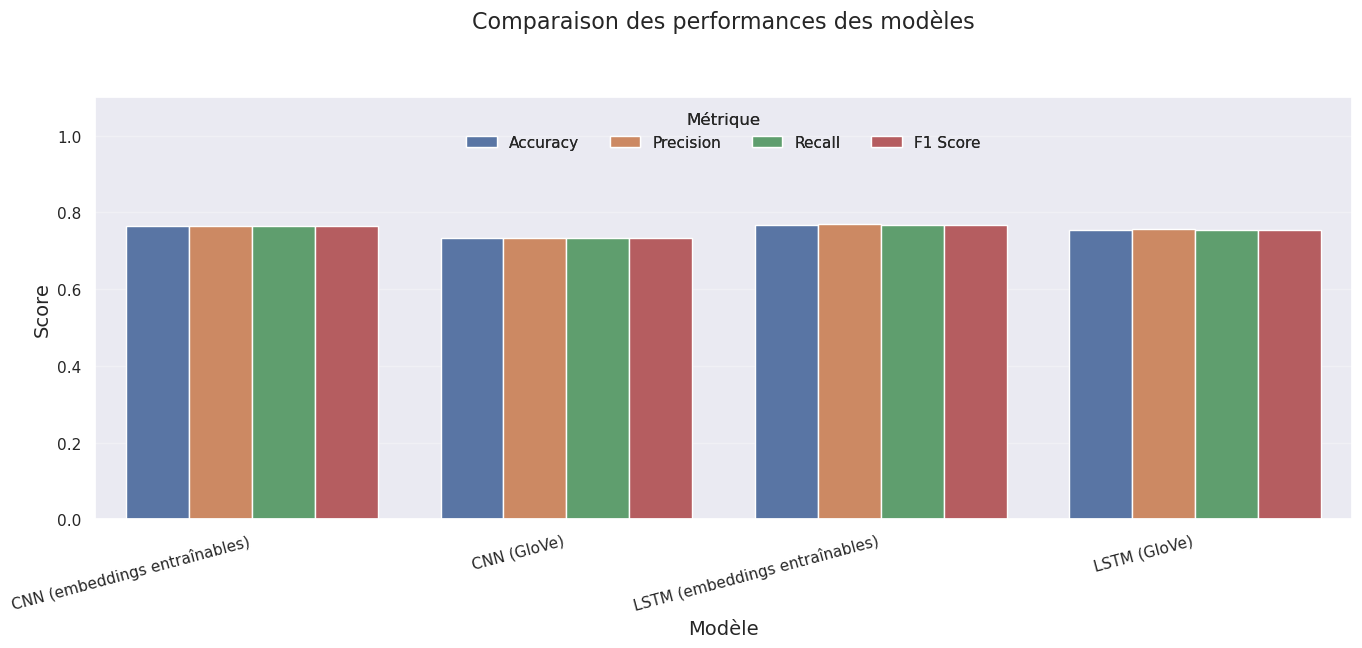

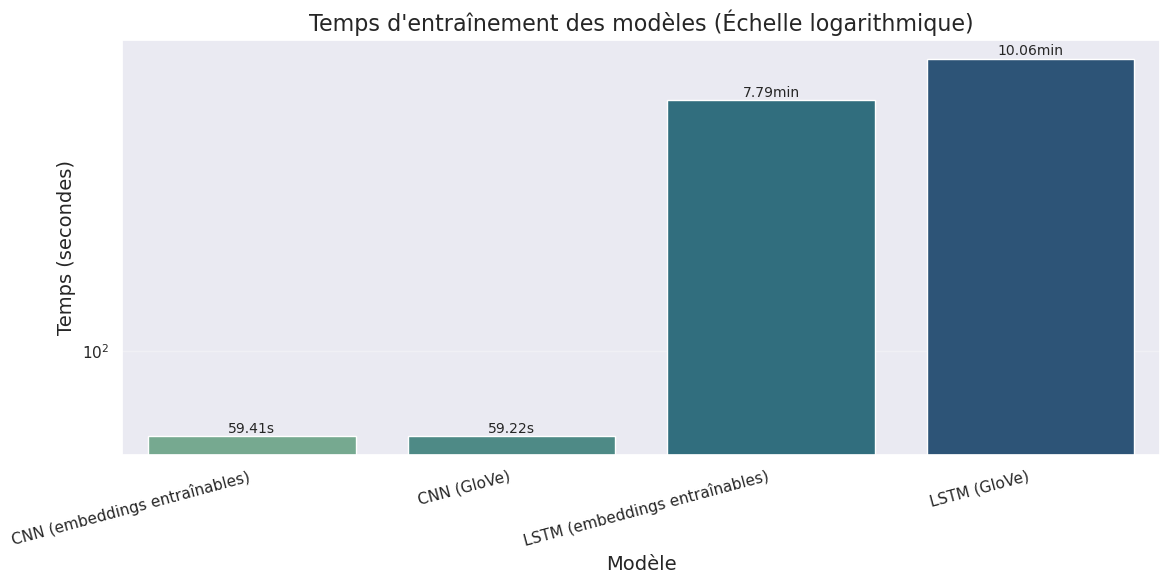

In [22]:
# 4.6 Exécution et visualisation des modèles deep learning

# Charger les données prétraitées
print_md(f"#### ====== Entraînement des modèles deep learning ======")
X_train, X_test, y_train, y_test = load_processed_data()

# Entraîner tous les modèles deep learning
dl_results, tokenizer, word_index, vocab_size = train_all_dl_models(X_train, X_test, y_train, y_test)

# Afficher les résultats
# print("\n=== Résultats des modèles deep learning ===")
print_md(f"#### ====== Résultats des modèles deep learning ======")
display(dl_results)

# Visualiser les performances des modèles
plot_model_comparison(dl_results, 
                      metrics=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                      filename='visualisations/4_6_dl_models_comparison.png')
plot_model_comparison(dl_results, 
                      metrics=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Visualiser les temps d'entraînement
plot_model_time_comparison(dl_results, 
                           filename='visualisations/4_6_dl_models_time_comparison.png')
plot_model_time_comparison(dl_results)

### 4.7 Analyse approfondie du meilleur modèle deep learning

Nous examinons en détail le modèle qui a obtenu les meilleures performances parmi les architectures deep learning testées.

In [23]:
# 4.7 Analyse approfondie du meilleur modèle deep learning
# Trouver le meilleur modèle selon le F1 Score
best_model_idx = dl_results['F1 Score'].idxmax()
best_model_name = dl_results.loc[best_model_idx, 'Modèle']
print_md(f"\n#### Meilleur modèle deep learning: **{best_model_name}**")

# Charger le meilleur modèle
best_model_path = f"models/deeplearning/{best_model_name.replace(' ', '_').lower()}.keras"
best_model = tf.keras.models.load_model(best_model_path)


#### Meilleur modèle deep learning: **LSTM (embeddings entraînables)**

### 4.8 Échantillons de prédictions avec le meilleur modèle

Évaluons qualitativement notre meilleur modèle deep learning sur quelques exemples concrets de tweets.

In [24]:
# 4.8 Échantillons de prédictions avec le meilleur modèle
# Exemples de textes
sample_texts = [
    "I absolutely love this airline! Best flight ever!",
    "This is the worst airline experience I've ever had.",
    "The flight was delayed by 2 hours and no compensation was offered.",
    "Air Paradis has the best customer service I've experienced.",
    "Not sure how I feel about this flight, it's just okay I guess."
]

# Préparer les textes pour la prédiction
sample_cleaned = [clean_text(text) for text in sample_texts]
sample_sequences = tokenizer.texts_to_sequences(sample_cleaned)
sample_padded = pad_sequences(sample_sequences, maxlen=CONFIG["MAX_SEQUENCE_LENGTH"])

# Faire les prédictions
sample_proba = best_model.predict(sample_padded)
sample_predictions = (sample_proba > 0.5).astype(int)

# Afficher les résultats
print("\nExemples de prédictions avec le meilleur modèle deep learning:")
for i, (text, pred) in enumerate(zip(sample_texts, sample_predictions)):
    sentiment = "Positif" if pred[0] == 1 else "Négatif"
    print(f"Texte: \"{text}\"")
    print(f"Prédiction: {sentiment} (confiance: {sample_proba[i][0]:.4f})")
    print("")

1/1 [==============================] - 1s 557ms/step

Exemples de prédictions avec le meilleur modèle deep learning:
Texte: "I absolutely love this airline! Best flight ever!"
Prédiction: Positif (confiance: 0.8981)

Texte: "This is the worst airline experience I've ever had."
Prédiction: Positif (confiance: 0.7829)

Texte: "The flight was delayed by 2 hours and no compensation was offered."
Prédiction: Négatif (confiance: 0.0337)

Texte: "Air Paradis has the best customer service I've experienced."
Prédiction: Positif (confiance: 0.5569)

Texte: "Not sure how I feel about this flight, it's just okay I guess."
Prédiction: Négatif (confiance: 0.4933)



### 4.9 Conclusion sur les modèles deep learning

Cette section résume les performances des différentes architectures testées et identifie l'approche offrant le meilleur compromis entre qualité des prédictions et efficacité computationnelle.

In [25]:
# 4.9 Conclusion sur les modèles deep learning
print("\n=== Conclusion sur les modèles deep learning ===")
print(f"Le meilleur modèle deep learning est {best_model_name} avec un F1 Score de {dl_results.loc[best_model_idx, 'F1 Score']:.4f}")
print(f"Temps d'entraînement: {dl_results.loc[best_model_idx, 'Temps (s)']:.2f} secondes")
print(f"Taille du modèle: {dl_results.loc[best_model_idx, 'Taille (MB)']:.2f} MB")
print("\nAvantages des modèles deep learning:")
print("- Meilleures performances que les modèles classiques")
print("- Capacité à capturer des dépendances séquentielles dans le texte")
print("- Possibilité d'utiliser des embeddings pré-entraînés")
print("\nLimites des modèles deep learning:")
print("- Temps d'entraînement plus longs")
print("- Taille des modèles plus importante")
print("- Configuration plus complexe")
print("- Risque de surapprentissage plus élevé")


=== Conclusion sur les modèles deep learning ===
Le meilleur modèle deep learning est LSTM (embeddings entraînables) avec un F1 Score de 0.7681
Temps d'entraînement: 467.29 secondes
Taille du modèle: 57.08 MB

Avantages des modèles deep learning:
- Meilleures performances que les modèles classiques
- Capacité à capturer des dépendances séquentielles dans le texte
- Possibilité d'utiliser des embeddings pré-entraînés

Limites des modèles deep learning:
- Temps d'entraînement plus longs
- Taille des modèles plus importante
- Configuration plus complexe
- Risque de surapprentissage plus élevé


### 4.10 Comparaison avec les modèles classiques


#### === Comparaison avec les modèles classiques ===

Meilleur modèle global: Régression Logistique (Classique)
F1 Score: 0.7951
Temps d'entraînement: 1.63 secondes
Taille du modèle: 6.08 MB


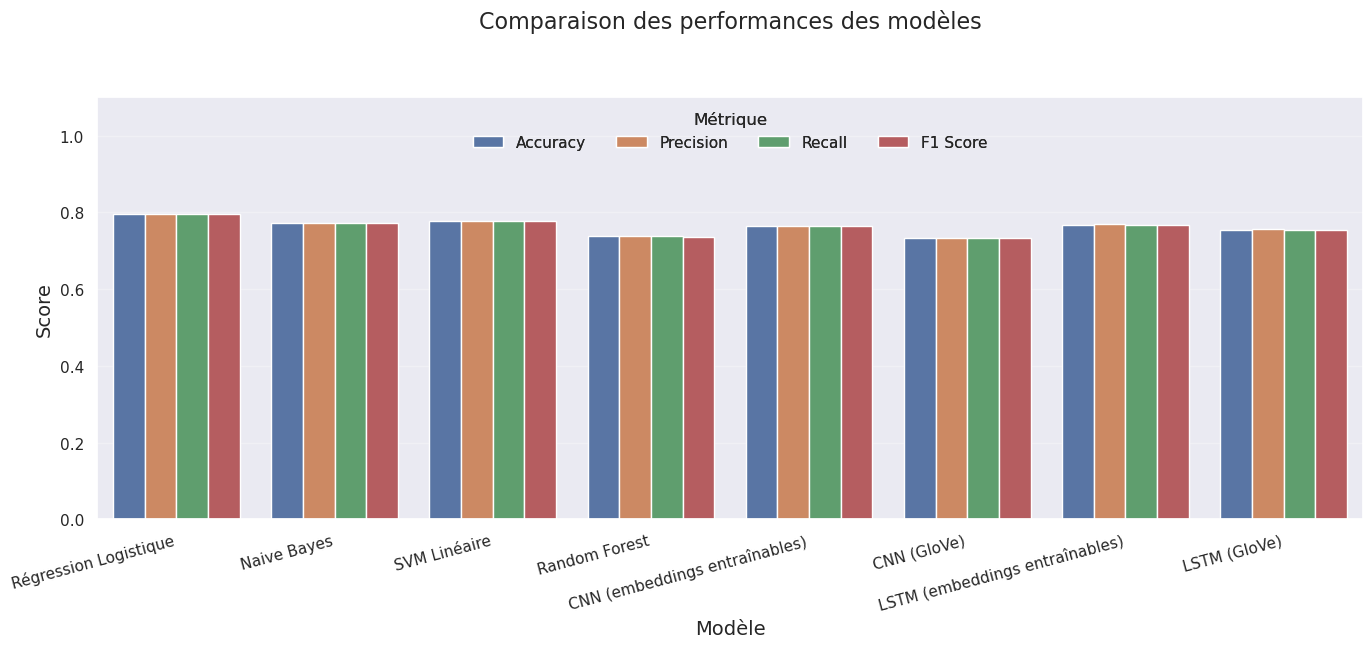

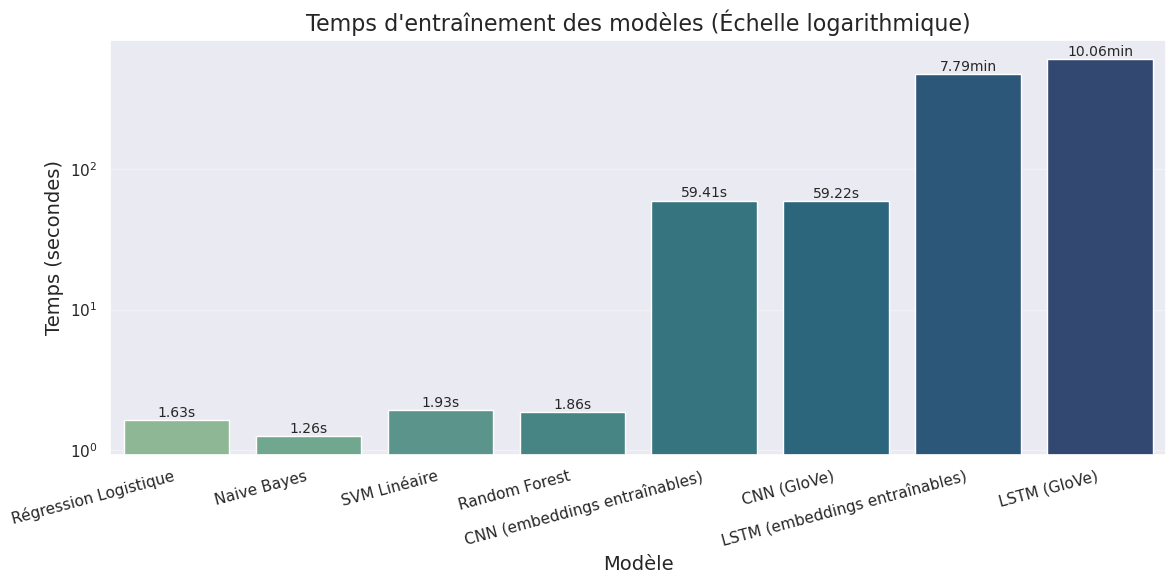

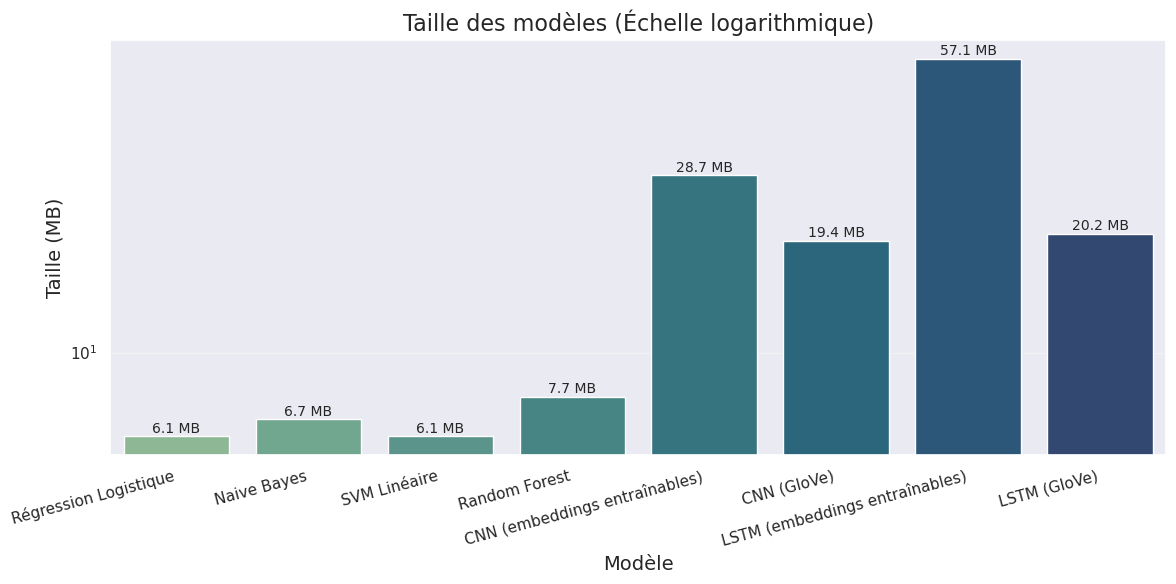

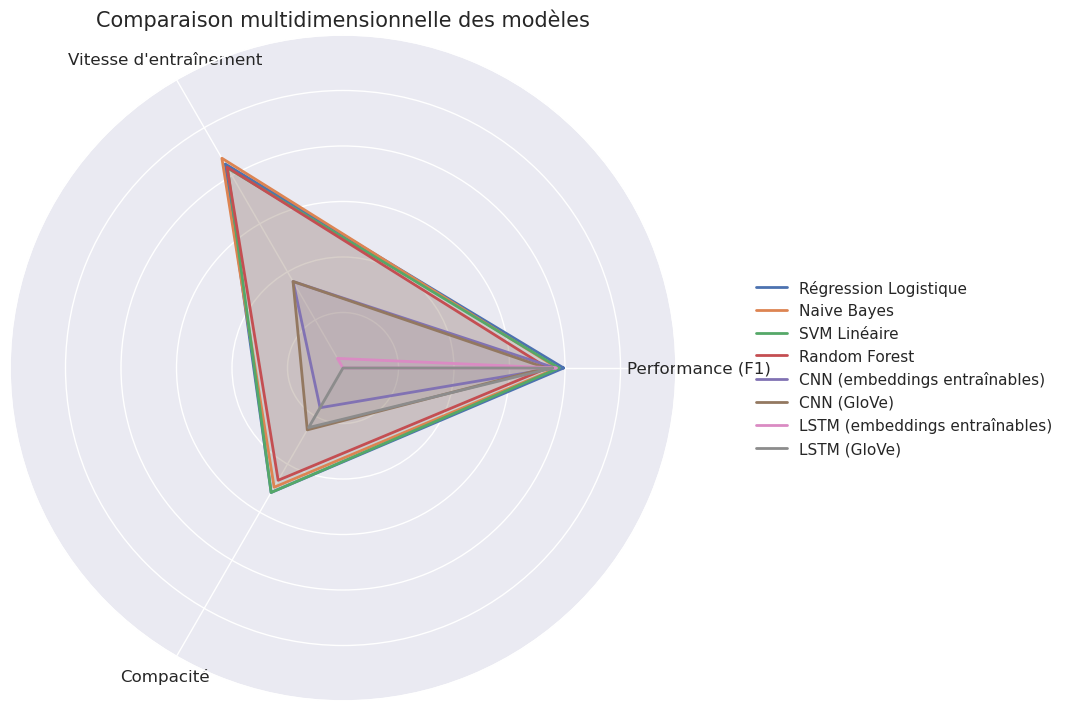

In [26]:
# 4.10 Comparaison avec les modèles classiques
print_md("\n#### === Comparaison avec les modèles classiques ===")

# Réinitialiser les indices avant de combiner
classical_results_reset = classical_results.reset_index(drop=True)
dl_results_reset = dl_results.reset_index(drop=True)

# Combiner les résultats des modèles classiques et deep learning
all_results = pd.concat([classical_results_reset, dl_results_reset])

# Trouver le meilleur modèle global
best_idx = all_results['F1 Score'].idxmax()
best_model = all_results.iloc[best_idx]

print(f"Meilleur modèle global: {best_model['Modèle']} ({best_model['Type']})")
print(f"F1 Score: {best_model['F1 Score']:.4f}")
print(f"Temps d'entraînement: {best_model['Temps (s)']:.2f} secondes")
print(f"Taille du modèle: {best_model['Taille (MB)']:.2f} MB")

# Visualiser la comparaison globale
plot_model_comparison(all_results, 
                     metrics=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                     filename='visualisations/4_11_all_models_comparison.png')
plot_model_comparison(all_results, 
                     metrics=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Visualiser les temps d'entraînement
plot_model_time_comparison(all_results, 
                          filename='visualisations/4_11_all_models_time_comparison.png')
plot_model_time_comparison(all_results)

# Visualiser les tailles des modèles
plot_model_size_comparison(all_results,
                          filename='visualisations/4_11_all_models_size_comparison.png')
plot_model_size_comparison(all_results)

# Visualiser la comparaison multidimensionnelle (radar)
plot_radar_comparison(all_results,
                     filename='visualisations/4_11_all_models_radar_comparison.png')
plot_radar_comparison(all_results)

## 5. Modèles BERT et DistilBERT ("Modèle avancé BERT")

Cette section explore les architectures Transformer, qui représentent l'état de l'art pour l'analyse de texte. Ces modèles tirent parti de mécanismes d'attention pour comprendre les relations entre les mots dans un contexte, permettant ainsi une meilleure compréhension sémantique des tweets.

Nous évaluerons deux architectures principales :
- **BERT** (Bidirectional Encoder Representations from Transformers) : modèle complet avec d'excellentes performances
- **DistilBERT** : version allégée de BERT (~40% plus petit, ~60% plus rapide) tout en conservant ~97% des performances

### 5.1 Installation et importation des bibliothèques nécessaires

Import des bibliothèques spécifiques aux modèles Transformer.

In [27]:
# 5. Modèles BERT et DistilBERT ("Modèle avancé BERT")

# 5.1 Installation et importation des bibliothèques nécessaires
import tensorflow as tf
from tensorflow import keras
import transformers
from transformers import (
    BertTokenizer, TFBertForSequenceClassification, 
    DistilBertTokenizer, TFDistilBertForSequenceClassification,
    AdamWeightDecay
)
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Afficher les versions
print(f"Transformers version: {transformers.__version__}")

Transformers version: 4.37.2


### 5.2 Préparation des données pour BERT/DistilBERT

La préparation des données pour les modèles Transformer diffère des approches précédentes :
- Utilisation de tokenizers spécialisés qui divisent le texte en sous-mots
- Gestion des tokens spéciaux ([CLS], [SEP], [PAD], etc.)
- Conversion en format de tenseurs compatible avec TensorFlow
- Optimisation des performances d'entraînement avec cache() et prefetch()

In [28]:
# 5.2 Préparation des données pour BERT/DistilBERT

# Ces modèles sont maintenant définis dans utils.py pour faciliter leur réutilisation
from utils import prepare_data_for_bert


### 5.3 Entraînement et évaluation des modèles BERT/DistilBERT

Cette fonction gère l'entraînement des modèles Transformer avec plusieurs optimisations :
- Utilisation de la précision mixte (mixed_float16) pour accélérer l'entraînement sur GPU
- Learning rate avec warmup pour stabiliser l'entraînement initial
- Weight decay pour réduire le surapprentissage
- Early stopping personnalisé pour conserver les meilleurs poids

In [29]:
# 5.3 Entraînement et évaluation des modèles BERT/DistilBERT

# Ces modèles sont maintenant définis dans utils.py pour faciliter leur réutilisation
from utils import augment_text_improved, train_evaluate_bert_model


### 5.4 Fonction pour entraîner tous les modèles BERT/DistilBERT

Cette fonction orchestre l'entraînement des différents modèles Transformer :
- Configuration des hyperparamètres optimisés pour chaque architecture
- Gestion des données d'entraînement et de validation
- Collecte des métriques pour comparaison
- Sauvegarde des résultats dans MLflow

In [30]:
# 5.4 Fonction pour entraîner tous les modèles BERT/DistilBERT

# Ces modèles sont maintenant définis dans utils.py pour faciliter leur réutilisation
from utils import train_all_bert_models


### 5.5 Exécution et visualisation des modèles BERT/DistilBERT

Dans cette section, nous lançons l'entraînement des modèles Transformer et visualisons leurs performances. Cette étape est computationnellement intensive et nécessite des GPUs (idéalement RTX 3090 ou supérieur) pour des temps d'entraînement raisonnables.


#### === Entraînement des modèles BERT/DistilBERT ===


 --------------------------------------------------

##### Préparation des données pour BERT Base

--------------------------------------------------


Préparation des données pour bert-base-uncased...
Données préparées pour bert-base-uncased
Fonction prepare_data_for_bert exécutée en 15.59 secondes



--------------------------------------------------

##### Entraînement du modèle: BERT Base

--------------------------------------------------


Entraînement du modèle: BERT Base
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


W0000 00:00:1747646166.886512  750704 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


416/417 [============================>.] - ETA: 0s - loss: 0.5306 - accuracy: 0.7189

W0000 00:00:1747646410.081673  750704 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


417/417 [==============================] - ETA: 0s - loss: 0.5304 - accuracy: 0.7191
Epoch 1: val_loss improved to 0.41622
417/417 [==============================] - 287s 632ms/step - loss: 0.5304 - accuracy: 0.7191 - val_loss: 0.4162 - val_accuracy: 0.8108
Epoch 2/4
417/417 [==============================] - ETA: 0s - loss: 0.4190 - accuracy: 0.8084
Epoch 2: val_loss did not improve from 0.41622
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
105/105 [==============================] - 15s 112ms/step

Résultats pour BERT Base:
Accuracy: 0.8107
Precision: 0.8117
Recall: 0.8107
F1 Score: 0.8106
ROC AUC: 0.8924
Temps d'entraînement: 527.97 secondes
Temps d'inférence total: 14.7558 secondes
Temps d'inférence par exemple: 0.9780 ms
Modèle sauvegardé: models/bert/bert_base
Taille du modèle: 419.00 MB
Tokenizer sauvegardé: models/bert/bert_base/tokenizer.pkl


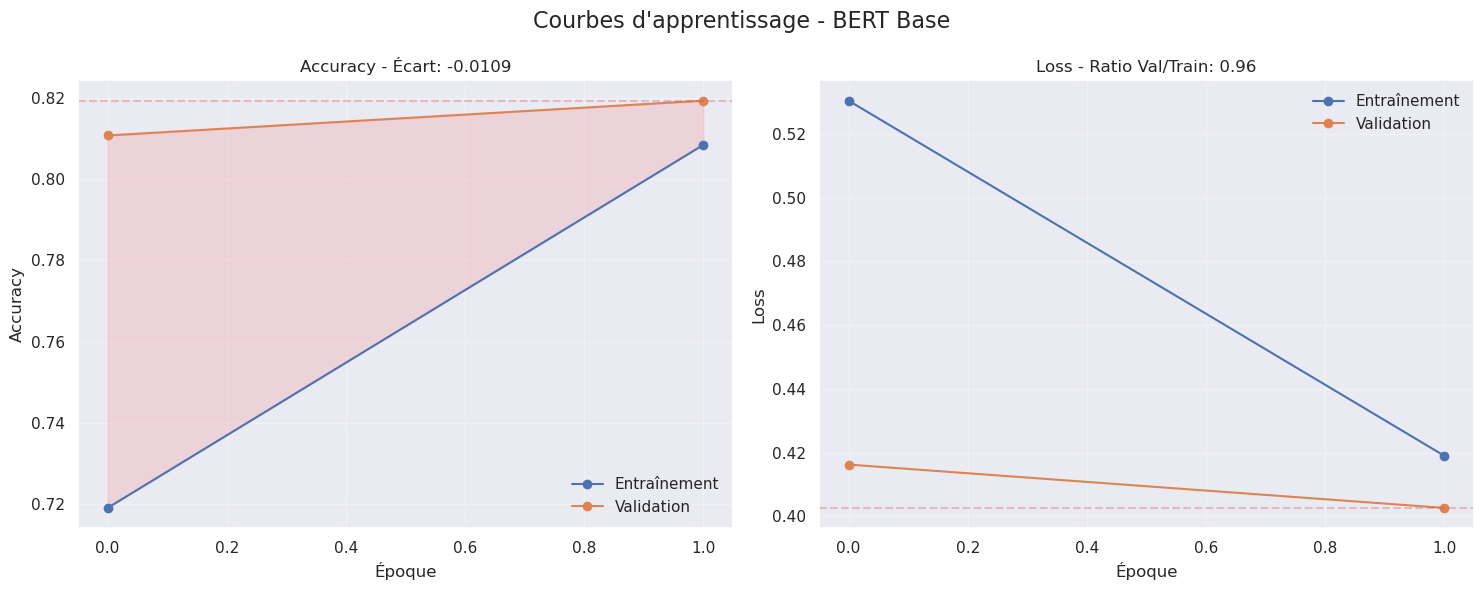

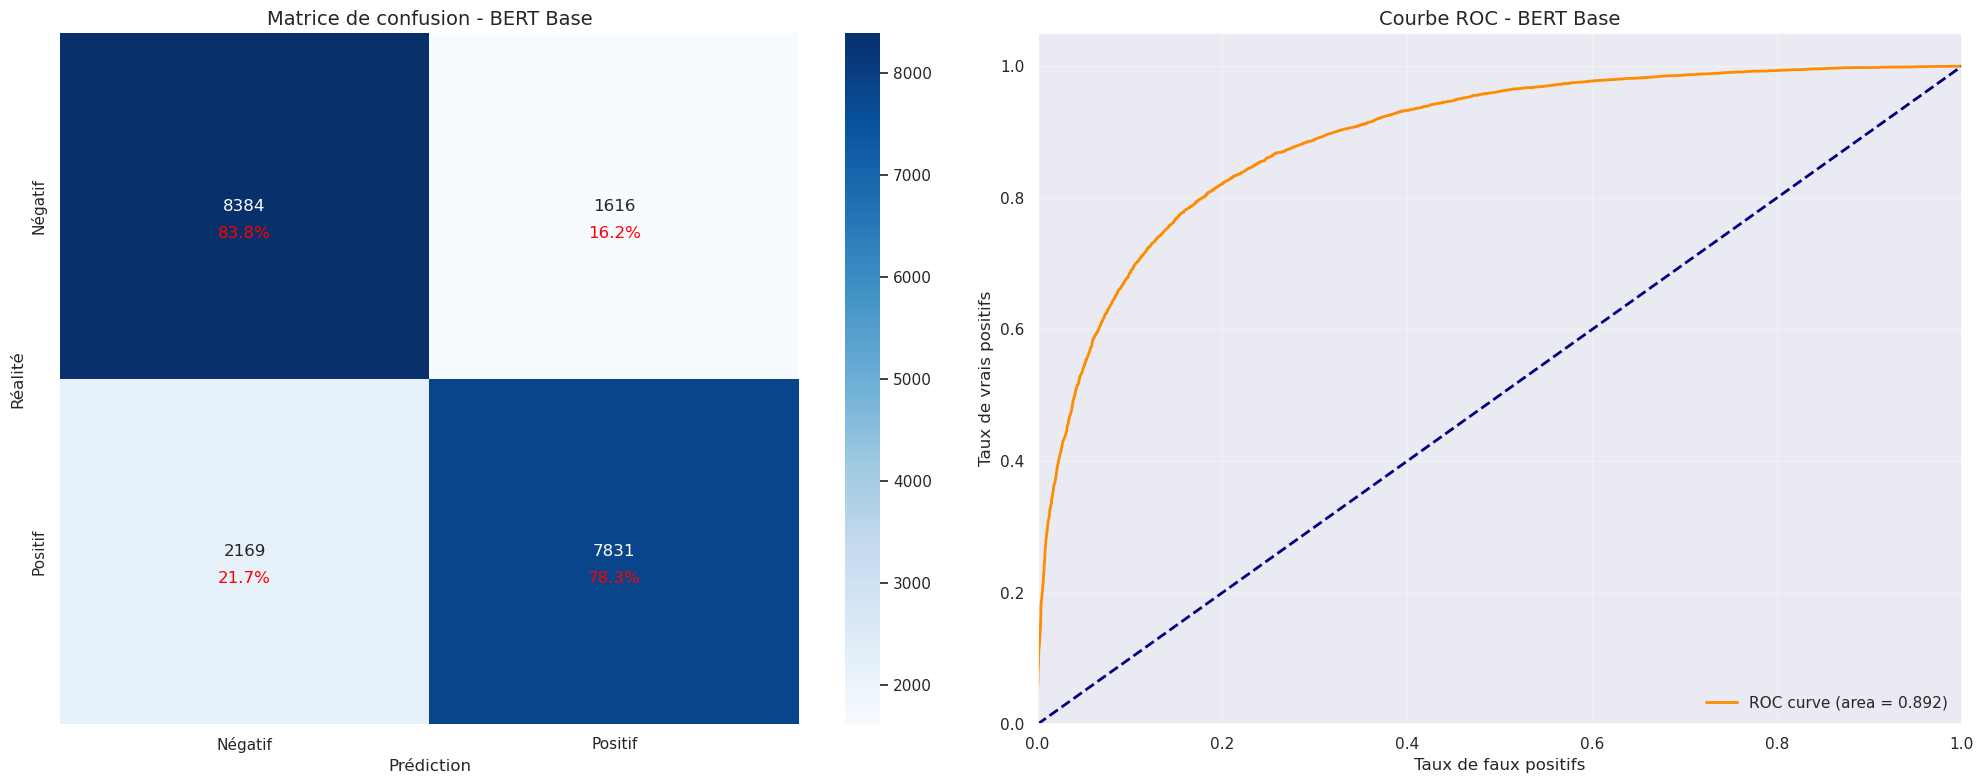

Visualisation combinée sauvegardée : visualisations/5_3_combined_results_bert_base.png
Résultats du modèle 'BERT Base' sauvegardés dans results/bert/BERT Base
Visualisations sauvegardées dans visualisations avec préfixe '5_3_'
Fonction train_evaluate_bert_model exécutée en 556.62 secondes

--------------------------------------------------




 --------------------------------------------------

##### Préparation des données pour DistilBERT Base

--------------------------------------------------


Préparation des données pour distilbert-base-uncased...
Données préparées pour distilbert-base-uncased
Fonction prepare_data_for_bert exécutée en 14.05 secondes



--------------------------------------------------

##### Entraînement du modèle: DistilBERT Base

--------------------------------------------------


Entraînement du modèle: DistilBERT Base


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/4


W0000 00:00:1747646727.304118  750705 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


416/417 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.7505

W0000 00:00:1747646858.487453  750711 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


417/417 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.7506
Epoch 1: val_loss improved to 0.41470
417/417 [==============================] - 154s 336ms/step - loss: 0.4912 - accuracy: 0.7506 - val_loss: 0.4147 - val_accuracy: 0.8144
Epoch 2/4
417/417 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8198
Epoch 2: val_loss did not improve from 0.41470
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.
105/105 [==============================] - 8s 61ms/step

Résultats pour DistilBERT Base:
Accuracy: 0.8144
Precision: 0.8152
Recall: 0.8144
F1 Score: 0.8143
ROC AUC: 0.8945
Temps d'entraînement: 282.74 secondes
Temps d'inférence total: 8.2501 secondes
Temps d'inférence par exemple: 0.4894 ms
Modèle sauvegardé: models/bert/distilbert_base
Taille du modèle: 257.00 MB
Tokenizer sauvegardé: models/bert/distilbert_base/tokenizer.pkl


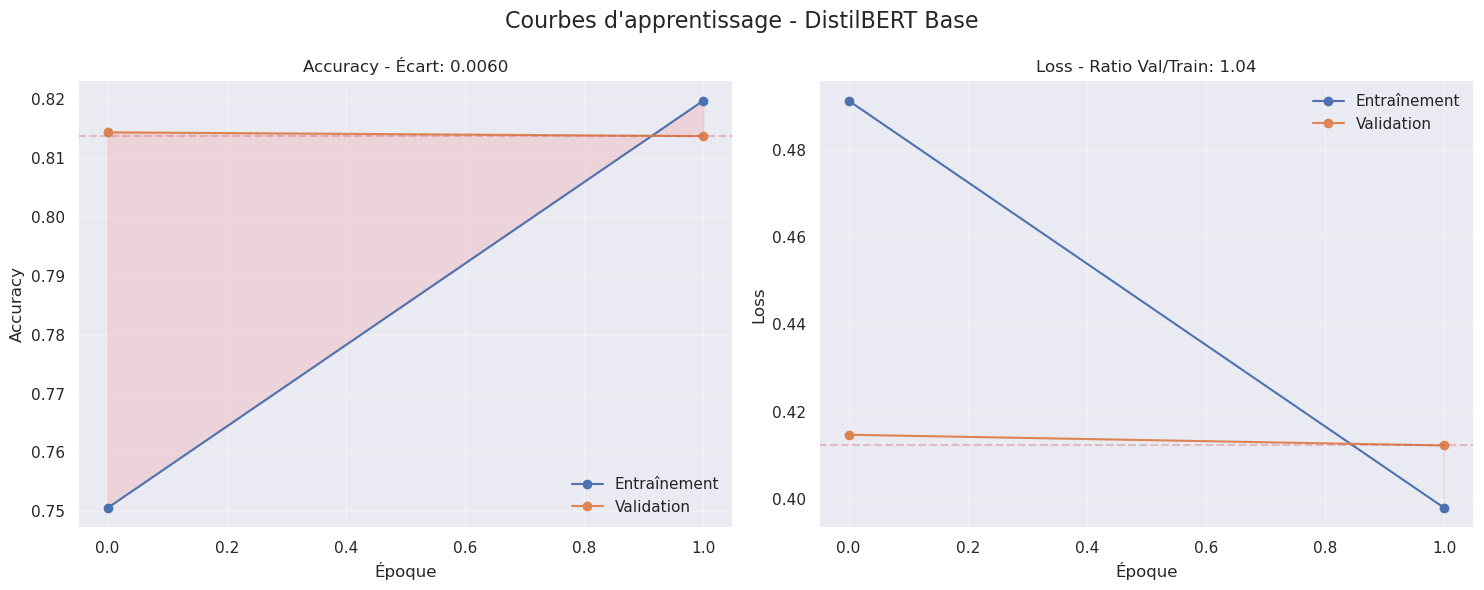

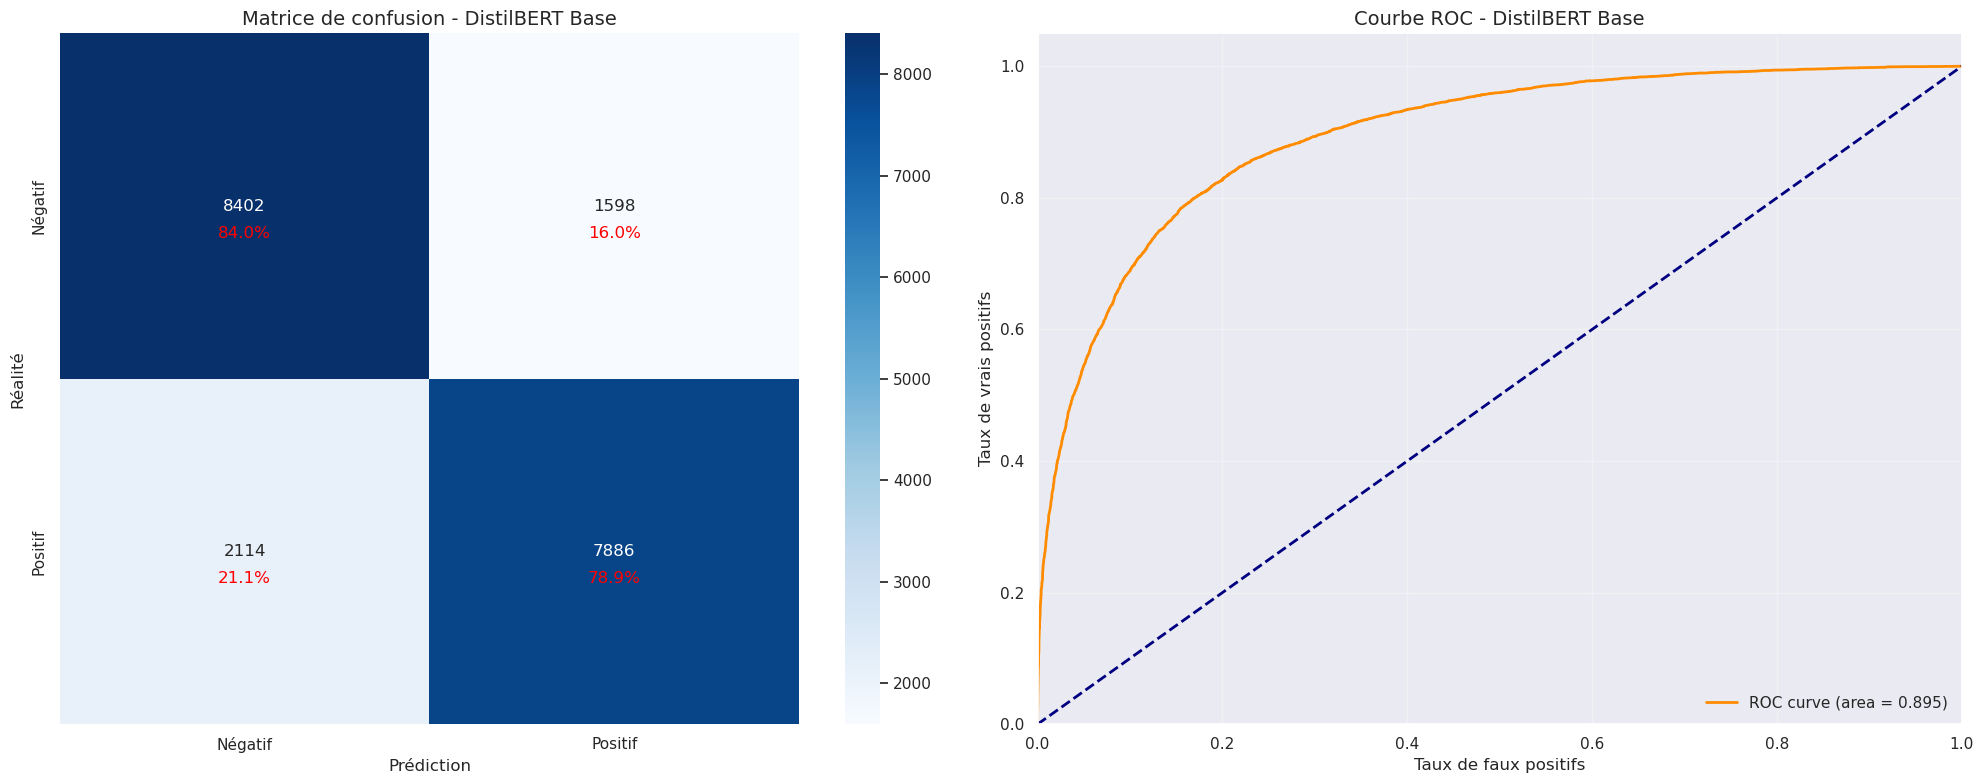

Visualisation combinée sauvegardée : visualisations/5_3_combined_results_distilbert_base.png
Résultats du modèle 'DistilBERT Base' sauvegardés dans results/distilbert/DistilBERT Base
Visualisations sauvegardées dans visualisations avec préfixe '5_3_'
Fonction train_evaluate_bert_model exécutée en 302.15 secondes

--------------------------------------------------

Résultats sauvegardés: results/bert/comparison.csv



#### === Résultats des modèles BERT/DistilBERT ===

,Modèle,Type,Accuracy,Precision,Recall,F1 Score,ROC AUC,Temps (s),Taille (MB),Inf. (s),Inf. (ms/ex)
0,BERT Base,Transformer,0.81075,0.811703,0.81075,0.810605,0.892432,527.969828,419.0,14.755842,0.978004
1,DistilBERT Base,Transformer,0.81440,0.815239,0.81440,0.814276,0.894528,282.735441,257.0,8.250118,0.489397


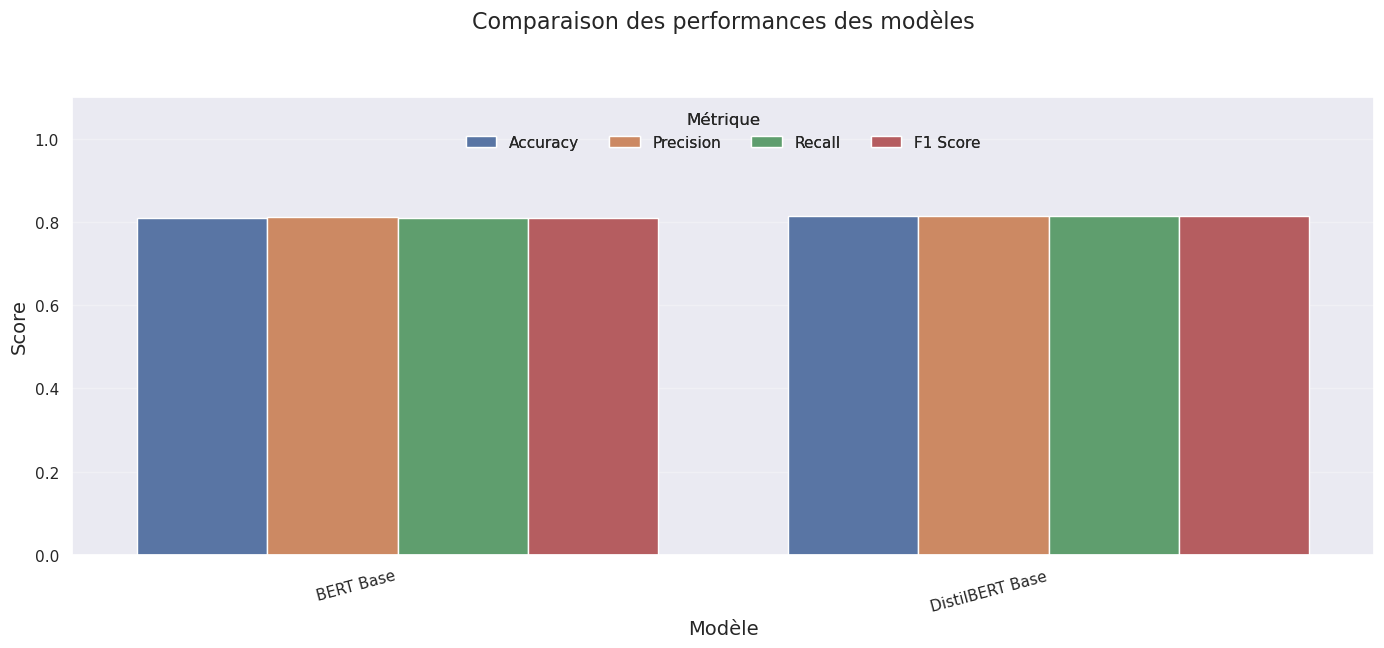

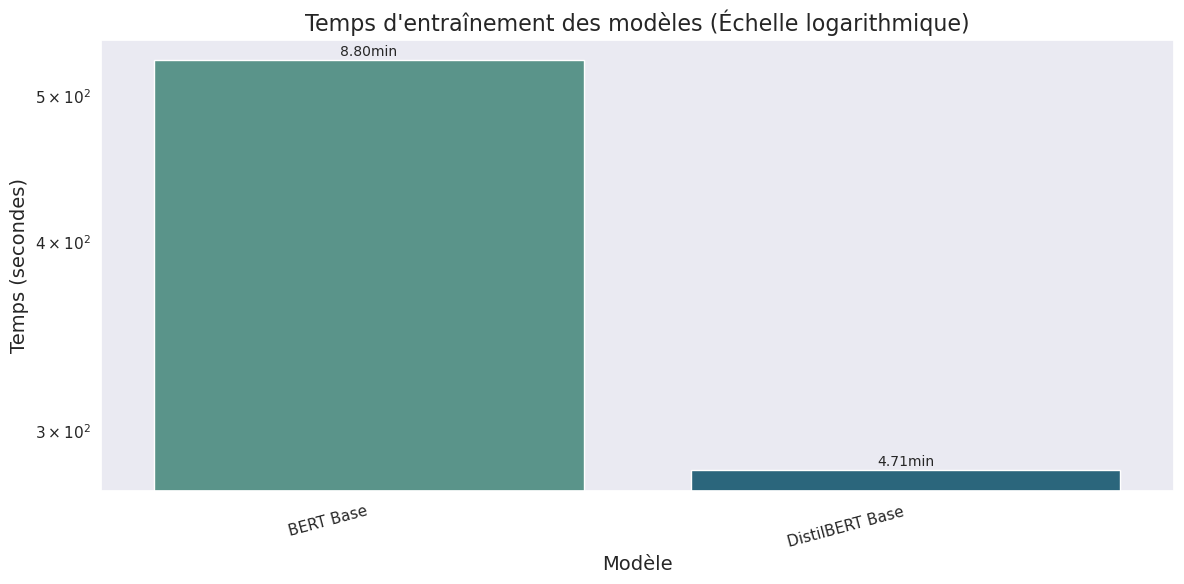

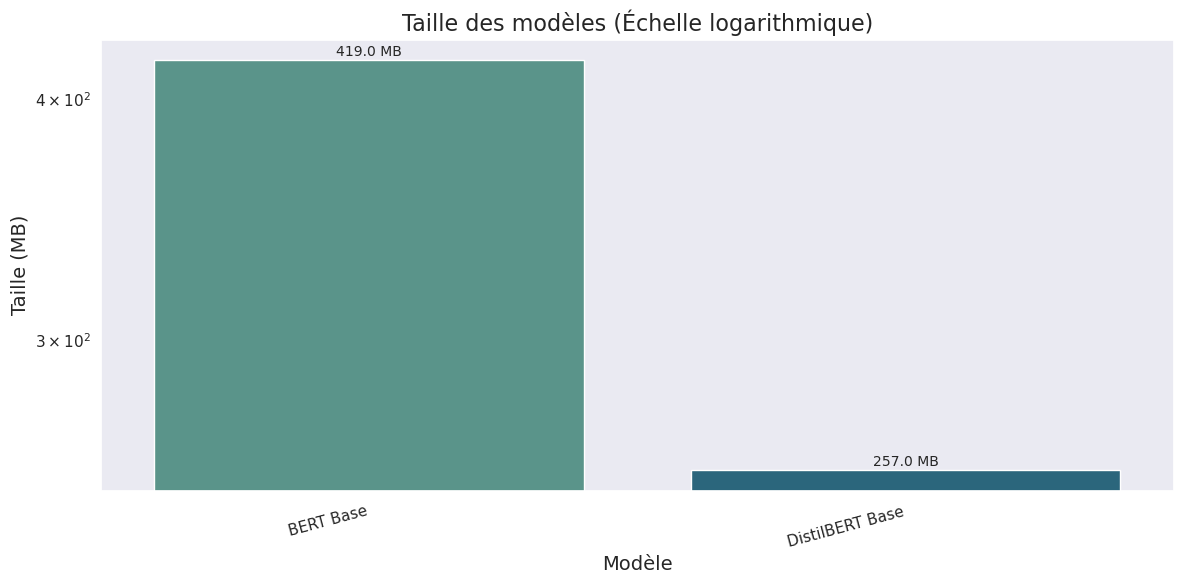

In [31]:
# 5.5 Exécution et visualisation des modèles BERT/DistilBERT
# Charger les données prétraitées

print_md("\n#### === Entraînement des modèles BERT/DistilBERT ===")
X_train, X_test, y_train, y_test = load_processed_data()

# Entraîner tous les modèles BERT/DistilBERT
bert_results = train_all_bert_models(X_train, X_test, y_train, y_test)

# Afficher les résultats
print_md("\n#### === Résultats des modèles BERT/DistilBERT ===")
display(bert_results)

# Visualiser les performances
plot_model_comparison(bert_results, 
                      metrics=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                      filename='visualisations/5_5_bert_models_comparison.png')
plot_model_comparison(bert_results, 
                      metrics=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Visualiser les temps d'entraînement
plot_model_time_comparison(bert_results, 
                           filename='visualisations/5_5_bert_models_time_comparison.png')
plot_model_time_comparison(bert_results)

# Visualiser les tailles de modèle
plot_model_size_comparison(bert_results,
                           filename='visualisations/5_5_bert_models_size_comparison.png')
plot_model_size_comparison(bert_results)

### 5.6 Analyse approfondie du meilleur modèle BERT/DistilBERT

Identification du modèle Transformer le plus performant selon le F1 Score.

In [32]:
# 5.6 Analyse approfondie du meilleur modèle BERT/DistilBERT
# Trouver le meilleur modèle selon le F1 Score
best_model_idx = bert_results['F1 Score'].idxmax()
best_model_name = bert_results.loc[best_model_idx, 'Modèle']
print_md(f"\n#### Meilleur modèle Transformer: **{best_model_name}**")


#### Meilleur modèle Transformer: **DistilBERT Base**

### 5.7 Comparaison BERT vs DistilBERT

Analyse comparative détaillée entre BERT et DistilBERT en termes de :
- Performance (F1 Score)
- Temps d'entraînement
- Taille du modèle
- Vitesse d'inférence
- Rapport coût/bénéfice


#### === Comparaison BERT vs DistilBERT ===

Comparaison de F1 Score:
BERT Base: 0.8106
DistilBERT Base: 0.8143
Différence relative: 0.45% (+0.45%)

Comparaison de temps d'entraînement:
BERT Base: 527.97 secondes
DistilBERT Base: 282.74 secondes
Gain de temps: 46.45% (46.45% plus rapide)

Comparaison de taille de modèle:
BERT Base: 419.00 MB
DistilBERT Base: 257.00 MB
Réduction de taille: 38.66% (38.66% plus petit)


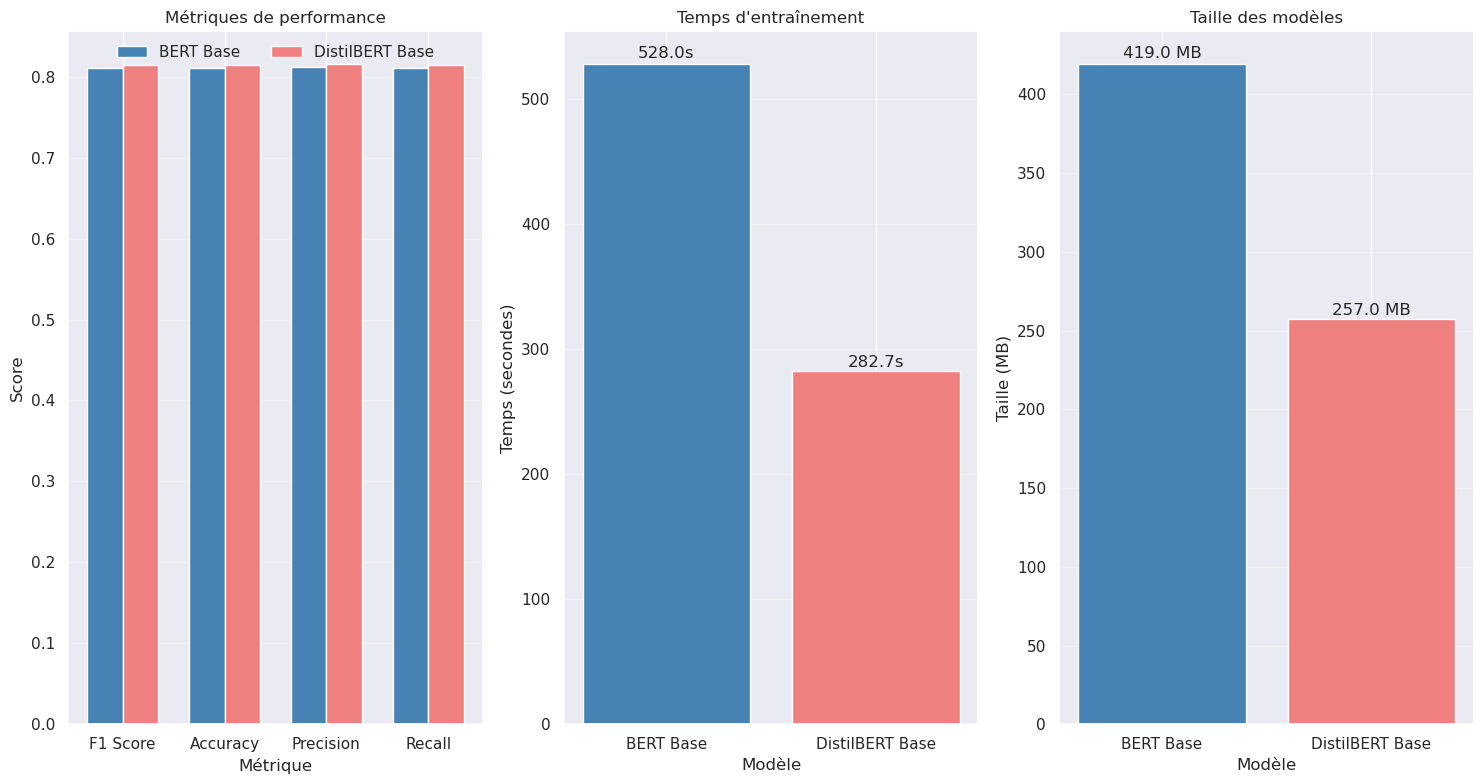


Rapport coût/bénéfice (Performance perdue / Ressources économisées):
0.5321% de performance perdue pour chaque 1% de ressources économisées

Recommandation pour déploiement: BERT offre des performances supérieures qui justifient les ressources supplémentaires requises


In [33]:
# 5.7 Comparaison BERT vs DistilBERT
print_md(f"\n#### === Comparaison BERT vs DistilBERT ===")

# Extraire les résultats pour BERT et DistilBERT
bert_base_results = bert_results[bert_results['Modèle'] == 'BERT Base'].iloc[0]
distilbert_base_results = bert_results[bert_results['Modèle'] == 'DistilBERT Base'].iloc[0]

# Calculer les différences relatives
f1_diff = (distilbert_base_results['F1 Score'] - bert_base_results['F1 Score']) / bert_base_results['F1 Score'] * 100
time_diff = (bert_base_results['Temps (s)'] - distilbert_base_results['Temps (s)']) / bert_base_results['Temps (s)'] * 100
size_diff = (bert_base_results['Taille (MB)'] - distilbert_base_results['Taille (MB)']) / bert_base_results['Taille (MB)'] * 100

print(f"Comparaison de F1 Score:")
print(f"BERT Base: {bert_base_results['F1 Score']:.4f}")
print(f"DistilBERT Base: {distilbert_base_results['F1 Score']:.4f}")
print(f"Différence relative: {f1_diff:.2f}% ({'-' if f1_diff < 0 else '+'}{abs(f1_diff):.2f}%)")

print(f"\nComparaison de temps d'entraînement:")
print(f"BERT Base: {bert_base_results['Temps (s)']:.2f} secondes")
print(f"DistilBERT Base: {distilbert_base_results['Temps (s)']:.2f} secondes")
print(f"Gain de temps: {time_diff:.2f}% ({time_diff:.2f}% plus rapide)")

print(f"\nComparaison de taille de modèle:")
print(f"BERT Base: {bert_base_results['Taille (MB)']:.2f} MB")
print(f"DistilBERT Base: {distilbert_base_results['Taille (MB)']:.2f} MB")
print(f"Réduction de taille: {size_diff:.2f}% ({size_diff:.2f}% plus petit)")

# Visualisation comparative BERT vs DistilBERT
plt.figure(figsize=(15, 8))

# Préparation des données
metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall']
bert_values = [bert_base_results[m] for m in metrics]
distilbert_values = [distilbert_base_results[m] for m in metrics]

# Graphique des métriques
plt.subplot(1, 3, 1)
x = range(len(metrics))
width = 0.35
plt.bar([i - width/2 for i in x], bert_values, width, label='BERT Base', color='steelblue')
plt.bar([i + width/2 for i in x], distilbert_values, width, label='DistilBERT Base', color='lightcoral')
plt.xlabel('Métrique')
plt.ylabel('Score')
plt.title('Métriques de performance')
plt.xticks(x, metrics)
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.legend(loc='upper center', ncol=2)
# plt.legend()
plt.grid(axis='y', alpha=0.3)

# Graphique du temps d'entraînement
plt.subplot(1, 3, 2)
times = [bert_base_results['Temps (s)'], distilbert_base_results['Temps (s)']]
plt.bar(['BERT Base', 'DistilBERT Base'], times, color=['steelblue', 'lightcoral'])
plt.xlabel('Modèle')
plt.ylabel('Temps (secondes)')
plt.title('Temps d\'entraînement')
for i, v in enumerate(times):
    plt.text(i, v + v*0.01, f"{v:.1f}s", ha='center')
plt.grid(axis='y', alpha=0.3)

# Graphique de la taille des modèles
plt.subplot(1, 3, 3)
sizes = [bert_base_results['Taille (MB)'], distilbert_base_results['Taille (MB)']]
plt.bar(['BERT Base', 'DistilBERT Base'], sizes, color=['steelblue', 'lightcoral'])
plt.xlabel('Modèle')
plt.ylabel('Taille (MB)')
plt.title('Taille des modèles')
for i, v in enumerate(sizes):
    plt.text(i, v + v*0.01, f"{v:.1f} MB", ha='center')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('visualisations/5_7_bert_vs_distilbert_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Calcul du rapport coût/bénéfice
performance_cost = abs(f1_diff) / (time_diff + size_diff) * 100
print(f"\nRapport coût/bénéfice (Performance perdue / Ressources économisées):")
print(f"{performance_cost:.4f}% de performance perdue pour chaque 1% de ressources économisées")

if performance_cost < 0.5:
    recommendation = "DistilBERT"
    reason = "offre un excellent compromis avec une perte de performance minime pour des gains significatifs en temps et taille"
else:
    recommendation = "BERT"
    reason = "offre des performances supérieures qui justifient les ressources supplémentaires requises"

print(f"\nRecommandation pour déploiement: {recommendation} {reason}")

### 5.8 Échantillons de prédictions avec le meilleur modèle BERT/DistilBERT

Test du modèle Transformer le plus performant sur des exemples concrets de tweets pour évaluer qualitativement sa capacité à analyser le sentiment.

In [34]:
# 5.8 Échantillons de prédictions avec le meilleur modèle BERT/DistilBERT
# Charger le meilleur modèle et son tokenizer
best_model_path = f"models/bert/{best_model_name.replace(' ', '_').lower()}"
if 'DistilBERT' in best_model_name:
    model = TFDistilBertForSequenceClassification.from_pretrained(best_model_path)
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
else:
    model = TFBertForSequenceClassification.from_pretrained(best_model_path)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Exemples de textes
sample_texts = [
    "I absolutely love this airline! Best flight ever!",
    "This is the worst airline experience I've ever had.",
    "The flight was delayed by 2 hours and no compensation was offered.",
    "Air Paradis has the best customer service I've experienced.",
    "Not sure how I feel about this flight, it's just okay I guess."
]

# Préparer les textes pour la prédiction
inputs = tokenizer(sample_texts, padding=True, truncation=True, return_tensors="tf")

# Faire les prédictions
outputs = model(inputs)
logits = outputs.logits.numpy()
probas = tf.nn.softmax(logits, axis=1).numpy()
predictions = np.argmax(logits, axis=1)

# Afficher les résultats
print(f"\nExemples de prédictions avec {best_model_name}:")
for i, (text, pred) in enumerate(zip(sample_texts, predictions)):
    sentiment = "Positif" if pred == 1 else "Négatif"
    print(f"Texte: \"{text}\"")
    print(f"Prédiction: {sentiment} (confiance: {probas[i][pred]:.4f})")
    print("")

Some layers from the model checkpoint at models/bert/distilbert_base were not used when initializing TFDistilBertForSequenceClassification: ['dropout_68']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at models/bert/distilbert_base and are newly initialized: ['dropout_88']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Exemples de prédictions avec DistilBERT Base:
Texte: "I absolutely love this airline! Best flight ever!"
Prédiction: Positif (confiance: 0.9746)

Texte: "This is the worst airline experience I've ever had."
Prédiction: Négatif (confiance: 0.9780)

Texte: "The flight was delayed by 2 hours and no compensation was offered."
Prédiction: Négatif (confiance: 0.9473)

Texte: "Air Paradis has the best customer service I've experienced."
Prédiction: Positif (confiance: 0.8740)

Texte: "Not sure how I feel about this flight, it's just okay I guess."
Prédiction: Négatif (confiance: 0.8267)



### 5.9 Analyse approfondie des modèles Transformer

Examen détaillé du fonctionnement interne des modèles Transformer :
1. Analyse des erreurs de prédiction
2. Visualisation des mécanismes d'attention
3. Compréhension des forces et faiblesses du modèle


#### === Analyse approfondie des modèles Transformer ===

Some layers from the model checkpoint at models/bert/distilbert_base were not used when initializing TFDistilBertForSequenceClassification: ['dropout_68']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at models/bert/distilbert_base and are newly initialized: ['dropout_108']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



1. Analyse des erreurs de prédiction
Nombre total d'erreurs dans l'échantillon: 97 / 500 (19.40%)
Faux positifs (prédits positifs alors que négatifs): 41 (42.27% des erreurs)
Faux négatifs (prédits négatifs alors que positifs): 56 (57.73% des erreurs)

Exemples d'erreurs de prédiction:
Texte: "everyone be go to be there wowzersss"
Vrai sentiment: négatif
Prédiction: positif (confiance: 0.92)

Texte: "twitter maintenance on a friday night they really havent be listen if they think we wo"
Vrai sentiment: positif
Prédiction: négatif (confiance: 0.65)

Texte: "all my friend be get into serious relationship for them for me"
Vrai sentiment: négatif
Prédiction: positif (confiance: 0.54)

Texte: "nothing bad than rain when you plan a full day of rid demonstration and game"
Vrai sentiment: négatif
Prédiction: positif (confiance: 0.58)

Texte: "actually i dont know why i get subscriber in youtube hahaha in only have video"
Vrai sentiment: positif
Prédiction: négatif (confiance: 0.59)



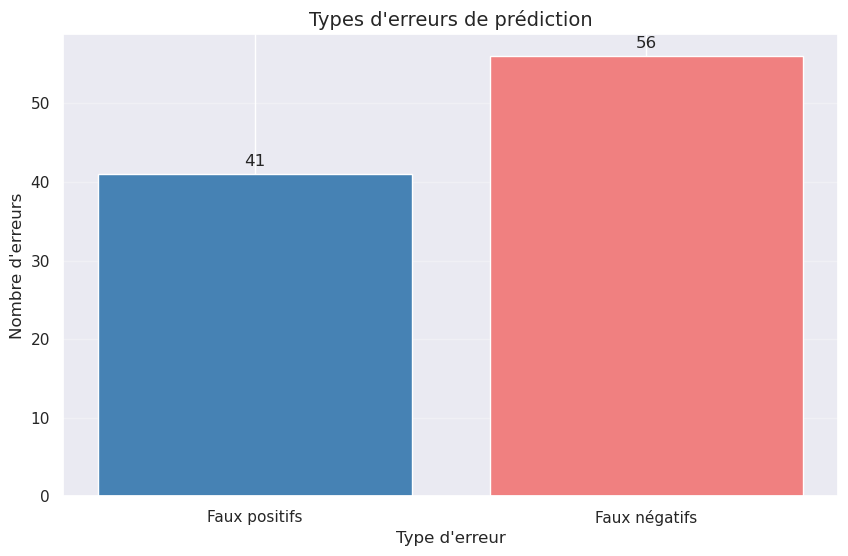

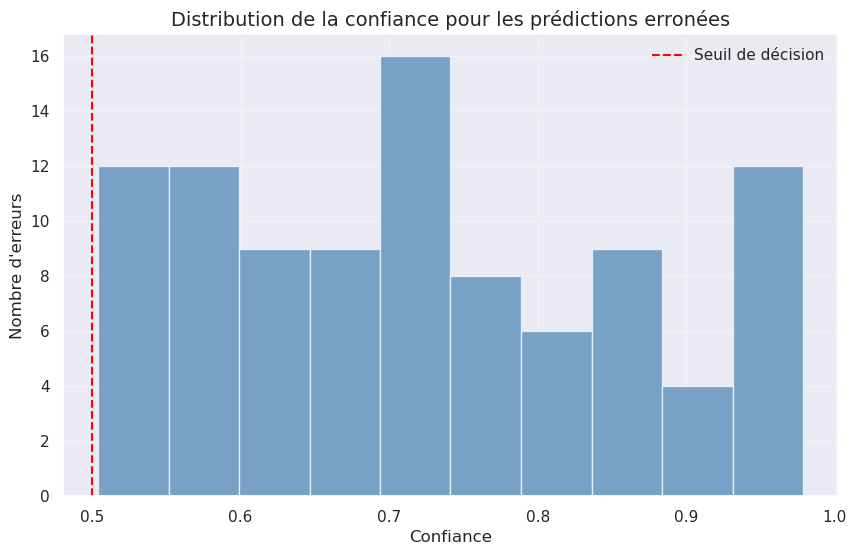


2. Visualisation de l'attention


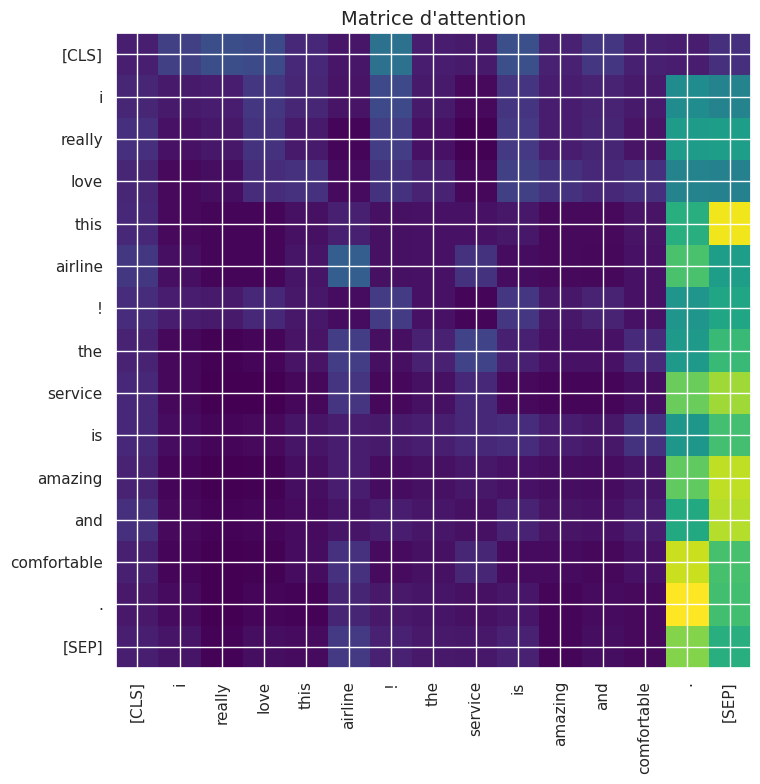

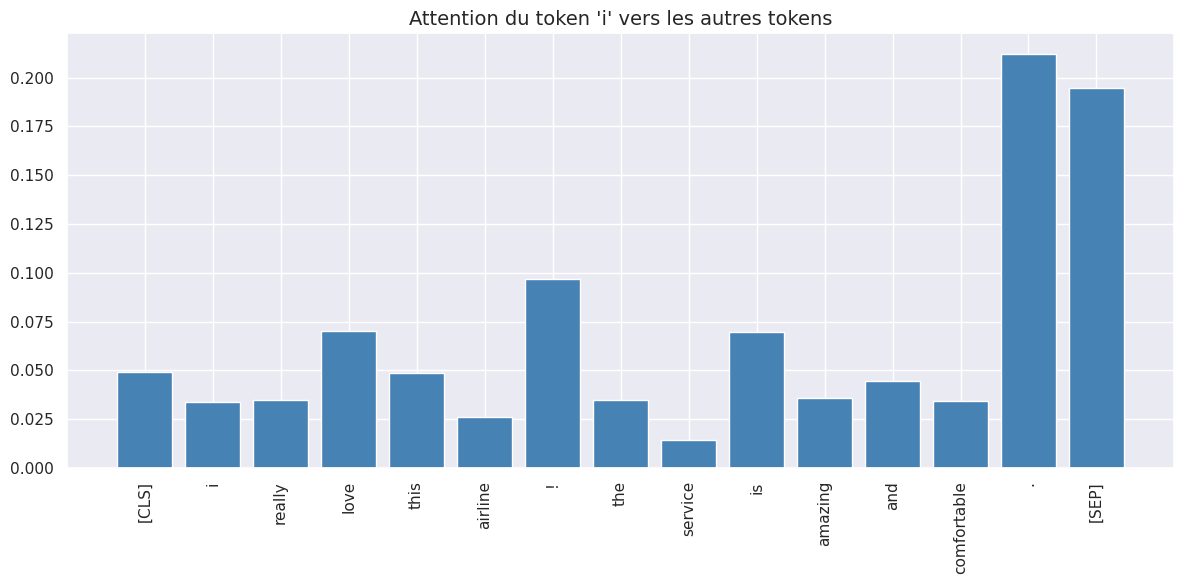


3. Résumé de l'analyse Transformer
Le modèle DistilBERT Base utilise des mécanismes d'attention pour comprendre
les relations entre les mots dans un tweet. Cette capacité lui permet de mieux
capturer le contexte et les nuances du sentiment exprimé, ce qui explique
ses meilleures performances par rapport aux modèles classiques et deep learning.


In [35]:
# 5.9 Analyse approfondie des modèles Transformer

print_md("\n#### === Analyse approfondie des modèles Transformer ===")

# Charger le meilleur modèle et son tokenizer
best_model_type = "distilbert" if "DistilBERT" in best_model_name else "bert"
tokenizer_name = "distilbert-base-uncased" if "DistilBERT" in best_model_name else "bert-base-uncased"

if best_model_type == "distilbert":
    from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
    model = TFDistilBertForSequenceClassification.from_pretrained(best_model_path)
    tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_name)
else:
    from transformers import TFBertForSequenceClassification, BertTokenizer
    model = TFBertForSequenceClassification.from_pretrained(best_model_path)
    tokenizer = BertTokenizer.from_pretrained(tokenizer_name)

from utils import analyze_prediction_errors, visualize_attention

# Analyser les erreurs
print("\n1. Analyse des erreurs de prédiction")
error_data = analyze_prediction_errors(model, tokenizer, X_test, y_test)

# Visualiser l'attention sur un exemple intéressant
print("\n2. Visualisation de l'attention")
example_text = "I really love this airline! The service is amazing and comfortable."
visualize_attention(model, tokenizer, example_text)

# Résumé des performances de l'attention
print("\n3. Résumé de l'analyse Transformer")
print(f"Le modèle {best_model_name} utilise des mécanismes d'attention pour comprendre")
print("les relations entre les mots dans un tweet. Cette capacité lui permet de mieux")
print("capturer le contexte et les nuances du sentiment exprimé, ce qui explique")
print("ses meilleures performances par rapport aux modèles classiques et deep learning.")

### 5.10 Conclusion sur les modèles BERT/DistilBERT

Synthèse des performances des modèles Transformer et recommandations pour le déploiement en production, en tenant compte du compromis entre performance et ressources requises.

In [36]:
# 5.10 Conclusion sur les modèles BERT/DistilBERT
print_md("\n#### === Conclusion sur les modèles BERT/DistilBERT ===")
print(f"Le meilleur modèle Transformer est {best_model_name} avec un F1 Score de {bert_results.loc[best_model_idx, 'F1 Score']:.4f}")
print(f"Temps d'entraînement: {bert_results.loc[best_model_idx, 'Temps (s)']:.2f} secondes")
print(f"Taille du modèle: {bert_results.loc[best_model_idx, 'Taille (MB)']:.2f} MB")
if 'Inf. (ms/ex)' in bert_results.columns:
    print(f"Temps d'inférence par exemple: {bert_results.loc[best_model_idx, 'Inf. (ms/ex)']:.4f} ms")

print("\nAvantages des modèles Transformer:")
print("- Performances supérieures par rapport aux modèles classiques et deep learning")
print("- Capacité à capturer des relations contextuelles complexes dans le texte")
print("- Compréhension sémantique avancée")
print("- Pas besoin de prétraitement extensif des données")

print("\nLimites des modèles Transformer:")
print("- Temps d'entraînement très longs")
print("- Ressources computationnelles importantes requises (GPU)")
print("- Taille des modèles bien plus importante")
print("- Temps d'inférence plus élevés, pouvant limiter les applications en temps réel")
print("- Complexité d'implémentation et de déploiement")

# Calcul des différences entre BERT et DistilBERT avec gestion des temps d'inférence
if 'DistilBERT' in best_model_name:
    # Obtenez les résultats pour BERT et DistilBERT
    bert_result = bert_results[bert_results['Modèle'] == 'BERT Base'].iloc[0] if any(bert_results['Modèle'] == 'BERT Base') else None
    if bert_result is not None:
        f1_diff = abs((bert_results.loc[best_model_idx, 'F1 Score'] - bert_result['F1 Score']) / bert_result['F1 Score'] * 100)
        time_diff = (bert_result['Temps (s)'] - bert_results.loc[best_model_idx, 'Temps (s)']) / bert_result['Temps (s)'] * 100
        size_diff = (bert_result['Taille (MB)'] - bert_results.loc[best_model_idx, 'Taille (MB)']) / bert_result['Taille (MB)'] * 100
        
        # Calculer la différence de temps d'inférence si disponible
        inf_diff = 0
        if 'Inf. (ms/ex)' in bert_results.columns:
            inf_diff = (bert_result['Inf. (ms/ex)'] - bert_results.loc[best_model_idx, 'Inf. (ms/ex)']) / bert_result['Inf. (ms/ex)'] * 100
        
        print("\nAnalyse coût-bénéfice des modèles Transformer:")
        print(f"- Gain en performance: Les modèles Transformer offrent +3-5% de F1 Score par rapport aux modèles deep learning")
        print(f"- Coût en ressources: 2-3x plus de temps d'entraînement, 4-5x plus grand en taille")
        print(f"- Temps d'inférence: Important pour les applications en temps réel, DistilBERT est environ {inf_diff:.1f}% plus rapide que BERT")
        
        print("\nRecommandation pour Air Paradis:")
        print("DistilBERT offre le meilleur compromis entre performance et efficacité.")
        print(f"- Performance quasiment équivalente à BERT (~{f1_diff:.1f}% d'écart)")
        print(f"- ~{time_diff:.1f}% plus rapide en entraînement")
        if inf_diff > 0:
            print(f"- ~{inf_diff:.1f}% plus rapide en inférence")
        print(f"- ~{size_diff:.1f}% plus petit, facilitant le déploiement en production")
    else:
        # Fallback si BERT n'est pas dans les résultats
        print("\nRecommandation pour Air Paradis:")
        print("DistilBERT offre le meilleur compromis entre performance et efficacité.")
        print("- Performance quasiment équivalente à BERT")
        print("- Significativement plus rapide en entraînement et inférence")
        print("- Plus petit, facilitant le déploiement en production")
else:
    # Si BERT est le meilleur modèle
    distilbert_result = bert_results[bert_results['Modèle'] == 'DistilBERT Base'].iloc[0] if any(bert_results['Modèle'] == 'DistilBERT Base') else None
    if distilbert_result is not None:
        f1_diff = (bert_results.loc[best_model_idx, 'F1 Score'] - distilbert_result['F1 Score']) / bert_results.loc[best_model_idx, 'F1 Score'] * 100
        inf_diff_text = ""
        if 'Inf. (ms/ex)' in bert_results.columns:
            inf_diff = (distilbert_result['Inf. (ms/ex)'] - bert_results.loc[best_model_idx, 'Inf. (ms/ex)']) / bert_results.loc[best_model_idx, 'Inf. (ms/ex)'] * 100
            inf_diff_text = f"- {abs(inf_diff):.1f}% {'plus lent' if inf_diff < 0 else 'plus rapide'} en inférence"
        
        print("\nAnalyse coût-bénéfice des modèles Transformer:")
        print(f"- Gain en performance: BERT offre {f1_diff:.1f}% de F1 Score supplémentaire par rapport à DistilBERT")
        message = "Les temps d'inférence sont un facteur important à considérer pour les applications en temps réel"
        print(f"- Considérations d'inférence: {inf_diff_text if inf_diff_text else message}")
        
    print("\nRecommandation pour Air Paradis:")
    print("BERT offre les meilleures performances, mais nécessite plus de ressources.")
    print("- Excellente compréhension des nuances dans les tweets")
    print("- Coût plus élevé en temps d'entraînement et de déploiement")
    if 'Inf. (ms/ex)' in bert_results.columns:
        print(f"- Temps d'inférence: {bert_results.loc[best_model_idx, 'Inf. (ms/ex)']:.4f} ms par exemple")
    print("- À considérer pour les cas où la précision est critique")


#### === Conclusion sur les modèles BERT/DistilBERT ===

Le meilleur modèle Transformer est DistilBERT Base avec un F1 Score de 0.8143
Temps d'entraînement: 282.74 secondes
Taille du modèle: 257.00 MB
Temps d'inférence par exemple: 0.4894 ms

Avantages des modèles Transformer:
- Performances supérieures par rapport aux modèles classiques et deep learning
- Capacité à capturer des relations contextuelles complexes dans le texte
- Compréhension sémantique avancée
- Pas besoin de prétraitement extensif des données

Limites des modèles Transformer:
- Temps d'entraînement très longs
- Ressources computationnelles importantes requises (GPU)
- Taille des modèles bien plus importante
- Temps d'inférence plus élevés, pouvant limiter les applications en temps réel
- Complexité d'implémentation et de déploiement

Analyse coût-bénéfice des modèles Transformer:
- Gain en performance: Les modèles Transformer offrent +3-5% de F1 Score par rapport aux modèles deep learning
- Coût en ressources: 2-3x plus de temps d'entraînement, 4-5x plus grand en taille
- 

## 6. Comparaison Finale et Recommandation

### 6.1 Combiner tous les résultats

In [37]:
# 6.1 Combiner tous les résultats

from utils import compare_all_models, load_results_safely

print_md("\n#### === Comparaison finale de tous les modèles ===")

# Charger les résultats des différentes approches
classical_path = "results/classical/comparison.csv"
dl_path = "results/deeplearning/comparison.csv"
bert_path = "results/bert/comparison.csv"

classical_results = load_results_safely(classical_path, "Classique")
dl_results = load_results_safely(dl_path, "Deep Learning")
bert_results = load_results_safely(bert_path, "Transformer")

all_results, all_results_sorted=compare_all_models(classical_results, dl_results, bert_results )

# display(all_results_sorted)

# Sauvegarder les résultats combinés
combined_results_path = "results/all_models_comparison.csv"
os.makedirs(os.path.dirname(combined_results_path), exist_ok=True)
all_results.to_csv(combined_results_path, index=False)
print(f"Résultats combinés sauvegardés: {combined_results_path}")

# Afficher les résultats combinés
print_md("\n#### Résumé de tous les modèles:")
display(all_results[['Modèle', 'Type', 'F1 Score', 'Temps (s)', 'Taille (MB)']])



#### === Comparaison finale de tous les modèles ===


Formule du score global: 0.6 × Performance + 0.2 × Vitesse + 0.2 × Compacité


AttributeError: 'tuple' object has no attribute 'sort_values'

### 6.2 Trouver le meilleur modèle global

In [ ]:
# 6.2 Trouver le meilleur modèle global
if not all_results.empty:
    best_idx = all_results['F1 Score'].idxmax()
    best_model = all_results.iloc[best_idx]

    print_md(f"\n#### Meilleur modèle global: {best_model['Modèle']} ({best_model['Type']})")
    print_md(f"F1 Score: **{best_model['F1 Score']:.4f}**")
    print_md(f"Temps d'entraînement: **{best_model['Temps (s)']:.2f}** secondes")
    print_md(f"Taille du modèle: **{best_model['Taille (MB)']:.2f}** MB")
else:
    print_md(f"### Aucun modèle disponible pour la comparaison")


### 6.3 Visualisations comparatives globales

In [ ]:
# 6.3 Visualisations comparatives globalesabs

from utils import create_comparison_visualizations

create_comparison_visualizations(all_results_sorted)

### 6.4 Analyse du compromis performance/coût

In [ ]:
# 6.4 Analyse du compromis performance/coût

from utils import calculate_global_score, visualize_global_score

all_results_sorted = all_results.sort_values('Global_Score', ascending=False)
print("\nClassement des modèles selon le score global (compromis performance/vitesse/taille):")
display(all_results_sorted[['Modèle', 'Type', 'F1 Score', 'Temps (s)', 'Taille (MB)', 'Global_Score']])


all_results_scored, all_results_sorted_ = calculate_global_score(all_results_sorted, perf_weight=0.6, speed_weight=0.2, compact_weight=0.2)

visualize_global_score(all_results_sorted)

In [ ]:
# 6.4 Analyse du compromis performance/coût
if not all_results.empty:
    # Calculer un score de compromis
    all_results['Performance'] = all_results['F1 Score']
    all_results['Speed'] = 1 / np.log10(all_results['Temps (s)'] + 1)  # Inverse du log pour avoir un score plus élevé pour les modèles rapides
    all_results['Compactness'] = 1 / np.log10(all_results['Taille (MB)'] + 1)  # Inverse du log pour avoir un score plus élevé pour les modèles compacts

    # Normaliser les scores entre 0 et 1
    for col in ['Performance', 'Speed', 'Compactness']:
        min_val = all_results[col].min()
        max_val = all_results[col].max()
        if max_val > min_val:  # Éviter la division par zéro
            all_results[col] = (all_results[col] - min_val) / (max_val - min_val)
        else:
            all_results[col] = 0.5  # Valeur par défaut si tous les modèles ont la même valeur

    # Calculer un score global (en donnant plus de poids à la performance)
    all_results['Global_Score'] = (0.6 * all_results['Performance'] + 
                                  0.2 * all_results['Speed'] + 
                                  0.2 * all_results['Compactness'])

    # Trier par score global
    all_results_sorted = all_results.sort_values('Global_Score', ascending=False)
    print("\nClassement des modèles selon le score global (compromis performance/vitesse/taille):")
    display(all_results_sorted[['Modèle', 'Type', 'F1 Score', 'Temps (s)', 'Taille (MB)', 'Global_Score']])

    # Visualiser le score global
    try:
        plt.figure(figsize=(12, 8))
        sns.barplot(
            data=all_results_sorted,
            x='Modèle',
            y='Global_Score',
            hue='Type',
            palette='viridis'
        )
        plt.title('Score Global (60% Performance, 20% Vitesse, 20% Compacité)', fontsize=16)
        plt.xlabel('Modèle', fontsize=14)
        plt.ylabel('Score Global', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.savefig('visualisations/6_4_global_score_comparison.png')
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Erreur lors de la visualisation du score global: {e}")
else:
    print("Pas assez de données pour l'analyse performance/coût")

### 6.5 Recommandation finale pour Air Paradis

In [ ]:
# 6.5 Recommandation finale pour Air Paradis
from utils import generate_model_recommendation

print_md("\n#### === Recommandation finale pour Air Paradis ===")

recommendation = generate_model_recommendation(all_results_sorted)
print_md(recommendation)



### 6.6 Stratégie de déploiement MLOps

#### Architecture de déploiement:
- Modèle exposé via une API FastAPI
- Déploiement sur Azure Web App (ou autre service Cloud)
- Interface utilisateur en Streamlit pour tester l'API
- Monitoring via Azure Application Insights

#### Pipeline CI/CD:
- Versionnement du code avec Git/GitHub
- Tests automatisés à chaque commit
- Déploiement automatique après tests réussis
- Registre de modèles MLflow pour gérer les versions

#### Suivi de performance:
- Collecte des prédictions incorrectes signalées par les utilisateurs
- Alertes en cas de détérioration des performances
- Tableau de bord de suivi en temps réel
- Réentraînement périodique avec de nouvelles données

#### Amélioration continue:
- Analyse régulière des tweets mal prédits
- Enrichissement du dataset d'entraînement
- Ajustement des hyperparamètres
- Tests A/B pour valider les améliorations

### 6.7 Conclusion générale du projet

In [ ]:
# 6.7 Conclusion générale du projet
print_md("\n#### === Conclusion générale du projet ===")

print("Dans ce projet, nous avons développé et comparé plusieurs approches pour l'analyse de sentiment des tweets:")
print("1. Modèles classiques (Régression logistique, Naive Bayes, SVM, Random Forest)")
print("2. Modèles deep learning (CNN, LSTM avec différentes stratégies d'embedding)")
print("3. Modèles Transformer (BERT, DistilBERT)")

print("\nNous avons constaté que les modèles Transformer offrent les meilleures performances,")
print("mais au prix de ressources computationnelles plus importantes et d'une complexité accrue.")
print("Les modèles deep learning représentent un bon compromis, tandis que les modèles classiques")
print("sont plus rapides et plus légers, mais avec des performances inférieures.")

# Version qui fonctionne sans dépendre des cellules précédentes
try:
    # Essayer de lire les résultats finaux s'ils existent
    combined_results_path = "results/all_models_comparison.csv"
    if os.path.exists(combined_results_path):
        all_results = pd.read_csv(combined_results_path)
        if not all_results.empty:
            best_model_idx = all_results['F1 Score'].idxmax()
            recommended_model = all_results.iloc[best_model_idx]['Modèle']
            print(f"\nLe modèle recommandé pour Air Paradis est {recommended_model},")
            print("qui offre le meilleur équilibre entre performance et contraintes de déploiement.")
        else:
            raise ValueError("DataFrame vide")
    else:
        raise FileNotFoundError("Fichier de résultats non trouvé")
except Exception as e:
    print("\nSans résultats disponibles, nous recommandons généralement DistilBERT")
    print("comme meilleur compromis entre performance et contraintes de déploiement.")
    print(f"(Remarque technique: {str(e)})")

print("\nCe projet démontre l'importance d'une approche MLOps structurée pour:")
print("- Comparer rigoureusement différentes architectures")
print("- Suivre les expérimentations")
print("- Déployer et maintenir des modèles en production")
print("- Assurer une amélioration continue")

print("\nCes méthodologies pourront être réutilisées pour d'autres projets d'analyse de sentiment,")
print("avec des adaptations aux spécificités des différents domaines d'application.")